In [2]:

import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# --- Warning Handling ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# --- Configuration ---
PCA_N_COMPONENTS = 10
SVM_C_VALUES = [0.1, 1, 10, 50]
SVM_GAMMA_VALUES = ['scale', 'auto', 0.1]
SVM_KERNEL_VALUES = ['rbf', 'linear']
CV_FOLDS = 5 # Cross-validation folds for GridSearchCV
TEST_SET_SIZE = 0.5 # Proportion of original test data to use for the final test set (remaining is validation)
RANDOM_STATE = 42 # For reproducible splits and model initialization

In [4]:
# --- Load Data ---
#training_data="/kaggle/input/dnp3-training/Custom_DNP3_Parser_Training_Balanced.csv"
training_data="../DNP3_Intrusion_Detection_Dataset_Final/Training_Testing_Balanced_CSV_Files/Custom_DNP3_Parser/Custom_DNP3_Parser_Training_Balanced.csv"
#testing_data="/kaggle/input/dnp3-testing/Custom_DNP3_Parser_Testing_Balanced.csv"
testing_data="../DNP3_Intrusion_Detection_Dataset_Final/Training_Testing_Balanced_CSV_Files/Custom_DNP3_Parser/Custom_DNP3_Parser_Testing_Balanced.csv"

print("Loading data...")
try:
    train_data = pd.read_csv(training_data)
    original_test_data = pd.read_csv(testing_data)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure the input files are correctly placed in /kaggle/input/...")
    exit()

# --- List input files for verification ---
print("\nFiles in input directory:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("-" * 30)


Loading data...
Data loaded successfully.

Files in input directory:
------------------------------


In [5]:
# --- Feature Engineering and Preprocessing Function ---
def preprocess_data(df, is_training=True, fit_objects=None):
    print(f"\nPreprocessing {'Training' if is_training else 'Validation/Test'} Data (Scaling Only)...")
    df = df.copy()
    df.columns = df.columns.str.strip()

    if is_training:
        fit_objects = {
            'label_encoder': LabelEncoder(),
            'imputer': SimpleImputer(strategy='median'),
            'scaler': StandardScaler(),
            'ip_freq_maps': {},
            'dropped_all_nan_cols': [],
            'final_scaled_columns': [] # Store scaled columns before PCA
        }
    elif fit_objects is None:
        raise ValueError("fit_objects dictionary must be provided for validation/test data preprocessing.")

    if 'date' in df.columns:
        print("Engineering Date Features...")
        try:
            df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
            df['hour'] = df['date'].dt.hour
            df['minute'] = df['date'].dt.minute
            df['second'] = df['date'].dt.second
            df['dayofweek'] = df['date'].dt.dayofweek
            df.drop('date', axis=1, inplace=True)
            time_cols = ['hour', 'minute', 'second', 'dayofweek']
            for col in time_cols:
                 if col in df.columns:
                    df[col].fillna(df[col].median(), inplace=True)
        except Exception as e:
            print(f"Error processing 'date' column: {e}. Skipping date features.")
            if 'date' in df.columns:
                df.drop('date', axis=1, inplace=True)
    else:
        print("Warning: 'date' column not found.")

    for col in ['source IP', 'destination IP']:
        if col in df.columns:
            print(f"Encoding '{col}' Frequency...")
            map_name = f"{col}_freq_map"
            freq_col_name = f"{col}_freq"
            if is_training:
                freq_map = df[col].value_counts().to_dict()
                fit_objects['ip_freq_maps'][map_name] = freq_map
                df[freq_col_name] = df[col].map(freq_map)
                df[freq_col_name].fillna(0, inplace=True)
            else:
                freq_map = fit_objects['ip_freq_maps'].get(map_name, {})
                df[freq_col_name] = df[col].map(freq_map)
                df[freq_col_name].fillna(0, inplace=True)
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Warning: '{col}' column not found.")

    if 'flow ID' in df.columns:
        print("Converting 'flow ID'...")
        df['flow ID_numeric'] = pd.to_numeric(df['flow ID'], errors='coerce')
        df.drop('flow ID', axis=1, inplace=True)
    else:
        print("Warning: 'flow ID' column not found.")

    if 'firstPacketDIR' in df.columns:
        print("Mapping 'firstPacketDIR'...")
        df['firstPacketDIR'] = df['firstPacketDIR'].map({'MASTER': 0, 'OUTSTATION': 1})
        df['firstPacketDIR'].fillna(-1, inplace=True)
    else:
        print("Warning: 'firstPacketDIR' column not found.")

    columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')

    y = None
    y_encoded = None
    if 'Label' in df.columns:
        print("Processing Target Variable 'Label'...")
        y = df['Label'].fillna('Unknown')
        X = df.drop('Label', axis=1)
        print(f"Unique values in Label column: {y.unique()}")

        le = fit_objects['label_encoder']
        if is_training:
            y_encoded = le.fit_transform(y)
        else:
            seen_labels = set(le.classes_)
            current_labels = set(y.unique())
            unseen_labels = current_labels - seen_labels
            if unseen_labels:
                print(f"Warning: Found unseen labels in validation/test data: {unseen_labels}.")
                if 'Unknown' in seen_labels:
                    unknown_class_index = list(le.classes_).index('Unknown')
                    print("Mapping unseen labels to 'Unknown'.")
                    y_encoded = y.apply(lambda x: x if x in seen_labels else 'Unknown')
                    y_encoded = le.transform(y_encoded)
                else:
                    print("Attempting transform, may error later if unseen labels cannot be handled and 'Unknown' was not trained.")
                    try:
                        y_encoded = le.transform(y)
                    except ValueError:
                         print("ValueError during transform due to unseen labels and no 'Unknown' fallback.")
                         y_encoded = y
            else:
                 y_encoded = le.transform(y)
    else:
        print("Warning: 'Label' column not found. Assuming data is features only (X).")
        X = df

    print("Converting remaining feature columns to numeric...")
    feature_cols = X.columns.tolist()
    for col in feature_cols:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    if is_training:
        all_nan_cols = X.columns[X.isna().all()].tolist()
        if all_nan_cols:
            print(f"Warning: The following columns are entirely NaN after coercion: {all_nan_cols}")
            print("Dropping these columns before imputation.")
            X = X.drop(columns=all_nan_cols)
            fit_objects['dropped_all_nan_cols'] = all_nan_cols
            print(f"Shape of X after dropping all-NaN columns: {X.shape}")
    else:
        cols_to_drop_test = fit_objects.get('dropped_all_nan_cols', [])
        if cols_to_drop_test:
            print(f"Dropping columns found to be all-NaN during training: {cols_to_drop_test}")
            cols_to_drop_test_existing = [col for col in cols_to_drop_test if col in X.columns]
            X = X.drop(columns=cols_to_drop_test_existing)
            print(f"Shape of X after dropping corresponding all-NaN columns: {X.shape}")

    print(f"Features count before imputation: {X.shape[1]}")
    print("Imputing missing values (median strategy)...")
    imputer = fit_objects['imputer']
    if is_training:
        fit_objects['imputer'] = SimpleImputer(strategy='median')
        imputer = fit_objects['imputer']
        X_imputed = imputer.fit_transform(X)
    else:
        if not hasattr(imputer, 'statistics_'):
             raise RuntimeError("Imputer was not fitted during training.")
        X_imputed = imputer.transform(X)

    X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

    print("Scaling features...")
    scaler = fit_objects['scaler']
    if is_training:
        X_scaled = scaler.fit_transform(X_imputed_df)
    else:
        if not hasattr(scaler, 'scale_'):
             raise RuntimeError("Scaler was not fitted during training.")
        X_scaled = scaler.transform(X_imputed_df)

    X_scaled_df = pd.DataFrame(X_scaled, columns=X_imputed_df.columns, index=X_imputed_df.index)

    if is_training:
        fit_objects['final_scaled_columns'] = X_scaled_df.columns.tolist()
    else:
        final_scaled_columns = fit_objects.get('final_scaled_columns')
        if final_scaled_columns:
            X_scaled_df = X_scaled_df.reindex(columns=final_scaled_columns, fill_value=0)
        else:
            print("Warning: 'final_scaled_columns' not found in fit_objects. Column alignment might fail.")

    print(f"Preprocessing complete (scaling only). Final scaled feature shape: {X_scaled_df.shape}")

    if is_training:
        return X_scaled_df, y_encoded, fit_objects
    else:
        return X_scaled_df, y_encoded, None

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [11]:
print("\n--- Splitting Data ---")
if 'Label' in original_test_data.columns:
    val_data, test_data = train_test_split(
        original_test_data,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_STATE,
        stratify=original_test_data['Label']
    )
    print(f"Original Test Data split into Validation ({len(val_data)} samples) and Test ({len(test_data)} samples).")
else:
    val_data, test_data = train_test_split(
        original_test_data,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_STATE
    )
    print("Warning: 'Label' column not found in original test data. Cannot stratify split.")
    print(f"Original Test Data split into Validation ({len(val_data)} samples) and Test ({len(test_data)} samples).")


--- Splitting Data ---
Original Test Data split into Validation (900 samples) and Test (900 samples).


In [26]:
print("\n--- Preprocessing All Datasets (Scaling Only) ---")
X_train_scaled, y_train, fit_objects = preprocess_data(train_data, is_training=True)
X_val_scaled, y_val, _ = preprocess_data(val_data, is_training=False, fit_objects=fit_objects)
X_test_scaled, y_test, _ = preprocess_data(test_data, is_training=False, fit_objects=fit_objects)


--- Preprocessing All Datasets (Scaling Only) ---

Preprocessing Training Data (Scaling Only)...
Engineering Date Features...
Encoding 'source IP' Frequency...
Encoding 'destination IP' Frequency...
Converting 'flow ID'...
Mapping 'firstPacketDIR'...
Processing Target Variable 'Label'...
Unique values in Label column: ['REPLAY' 'COLD_RESTART' 'DNP3_INFO' 'DNP3_ENUMERATE' 'WARM_RESTART'
 'DISABLE_UNSOLICITED' 'NORMAL' 'INIT_DATA' 'STOP_APP']
Converting remaining feature columns to numeric...
Dropping these columns before imputation.
Shape of X after dropping all-NaN columns: (4194, 102)
Features count before imputation: 102
Imputing missing values (median strategy)...
Scaling features...
Preprocessing complete (scaling only). Final scaled feature shape: (4194, 102)

Preprocessing Validation/Test Data (Scaling Only)...
Engineering Date Features...
Encoding 'source IP' Frequency...
Encoding 'destination IP' Frequency...
Converting 'flow ID'...
Mapping 'firstPacketDIR'...
Processing Targe


--- PCA Analysis & Visualization ---


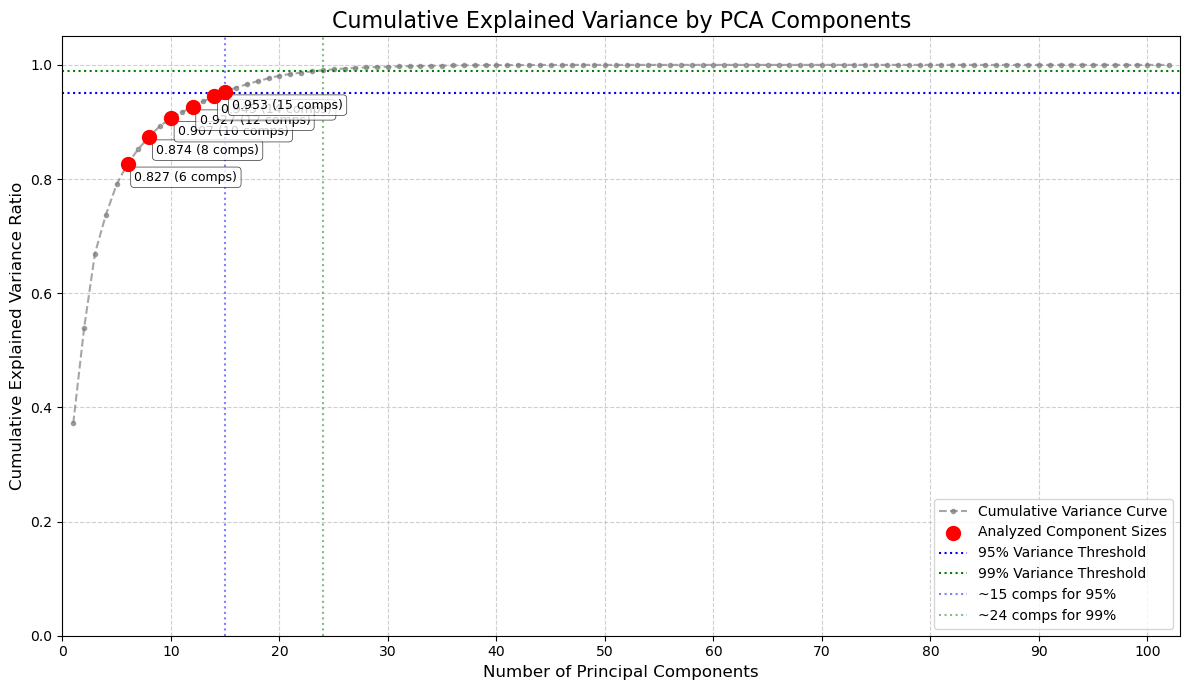


Applying PCA with the selected 15 components...
Shape after PCA: Train=(4194, 15), Val=(900, 15), Test=(900, 15)
Variance explained by 15 components: 0.9530


In [27]:
print("\n--- PCA Analysis & Visualization ---")

pca_analyzer = PCA(random_state=RANDOM_STATE) # Fit PCA 

pca_analyzer.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca_analyzer.explained_variance_ratio_)
total_possible_components = len(cumulative_variance)

component_sizes = [6, 8, 10, 12, 14, 15] # n_components array to compare
component_sizes = [n for n in component_sizes if 1 <= n <= total_possible_components]

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(range(1, total_possible_components + 1), cumulative_variance, marker='.', linestyle='--', label='Cumulative Variance Curve', color='grey', alpha=0.7)

# Highlight the specific component sizes
indices = [n - 1 for n in component_sizes] # get the 0-based indices
variances_at_components = cumulative_variance[indices]
plt.scatter(component_sizes, variances_at_components, color='red', s=100, zorder=5, label='Analyzed Component Sizes')
for n_components, variance in zip(component_sizes, variances_at_components):
    plt.annotate(f'{variance:.3f} ({n_components} comps)',
                 xy=(n_components, variance),
                 xytext=(5, -5), # Offset text slightly
                 textcoords='offset points',
                 ha='left',
                 va='top',
                 fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))

plt.axhline(0.95, linestyle=':', color='blue', label='95% Variance Threshold')
plt.axhline(0.99, linestyle=':', color='green', label='99% Variance Threshold')
try:
    components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    plt.axvline(components_95, linestyle=':', color='blue', alpha=0.5, label=f'~{components_95} comps for 95%')
except ValueError: pass # Threshold not reached
try:
    components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    plt.axvline(components_99, linestyle=':', color='green', alpha=0.5, label=f'~{components_99} comps for 99%')
except ValueError: pass # Threshold not reached

plt.title('Cumulative Explained Variance by PCA Components', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.ylim(0, 1.05) # Set y-axis limits
plt.xlim(0, total_possible_components + 1) # Set x-axis limits
plt.xticks(np.arange(0, total_possible_components + 1, step=max(1, total_possible_components // 10))) # Adjust x-ticks frequency
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()


n_components_selected = 15 # *** CHOSEN BASED ON PLOT/ANALYSIS ***

print(f"\nApplying PCA with the selected {n_components_selected} components...")
pca_final = PCA(n_components=n_components_selected, random_state=RANDOM_STATE)

X_train = pca_final.fit_transform(X_train_scaled) # Fit and transform training
X_val = pca_final.transform(X_val_scaled)         # Transform validation
X_test = pca_final.transform(X_test_scaled)        # Transform test

fit_objects['pca'] = pca_final

pca_cols = [f'PC_{i+1}' for i in range(X_train.shape[1])]
X_train = pd.DataFrame(X_train, columns=pca_cols, index=X_train_scaled.index)
X_val = pd.DataFrame(X_val, columns=pca_cols, index=X_val_scaled.index)
X_test = pd.DataFrame(X_test, columns=pca_cols, index=X_test_scaled.index)

# Store final column names
fit_objects['final_columns'] = pca_cols

print(f"Shape after PCA: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
explained_variance_selected = np.sum(pca_final.explained_variance_ratio_)
print(f"Variance explained by {n_components_selected} components: {explained_variance_selected:.4f}")


# --- Now you correctly have X_train, X_val, X_test (PCA transformed with 15 components) ---
# --- and y_train, y_val, y_test (original encoded targets) ---
# --- Ready for Data Validation, Model Training, Evaluation sections ---

In [28]:
print("\n--- Validating Preprocessed Data ---")
valid_data = True
if X_train is None or X_val is None or X_test is None:
    print("Error: Feature data (X) is None for one or more datasets.")
    valid_data = False
if y_train is None or y_val is None or y_test is None:
    print("Error: Target data (y) is None for one or more datasets.")
    valid_data = False
if X_train.empty or X_val.empty or X_test.empty:
    print("Error: Feature set is empty after preprocessing for one or more datasets.")
    valid_data = False
if np.any(np.isnan(X_train.values)) or np.any(np.isinf(X_train.values)):
     print("Error: NaNs or Infs found in X_train before model training.")
     valid_data = False
if np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
     print("Error: NaNs or Infs found in y_train before model training.")
     valid_data = False

if not valid_data:
    print("Cannot proceed with model training due to data issues.")
    exit()
else:
    print("Preprocessed data appears valid for training and evaluation.")


--- Validating Preprocessed Data ---
Preprocessed data appears valid for training and evaluation.


In [29]:
print("\n--- Setting up SVM Model and GridSearchCV ---")
svm_model = SVC(random_state=RANDOM_STATE, probability=True)

param_grid = {'C': SVM_C_VALUES,
              'gamma': SVM_GAMMA_VALUES,
              'kernel': SVM_KERNEL_VALUES}

print(f"Performing GridSearchCV (CV Folds = {CV_FOLDS})...")
print(f"Parameter Grid: {param_grid}")

grid_search = GridSearchCV(svm_model, param_grid, refit=True,
                           verbose=2, cv=CV_FOLDS, n_jobs=-1)

try:
    grid_search.fit(X_train, y_train)
    best_svm = grid_search.best_estimator_
    print("\nGridSearchCV finished.")
    print(f"Best Parameters found: {grid_search.best_params_}")
    print(f"Best Model: {best_svm}")
except ValueError as e:
    print(f"\nError during GridSearchCV fit: {e}")
    print("This might happen if labels contain unexpected values (check y_train) or if data shapes mismatch.")
    print(f"y_train contains NaNs/Infs: {np.any(np.isnan(y_train)) or np.any(np.isinf(y_train))}")
    exit()



--- Setting up SVM Model and GridSearchCV ---
Performing GridSearchCV (CV Folds = 5)...
Parameter Grid: {'C': [0.1, 1, 10, 50], 'gamma': ['scale', 'auto', 0.1], 'kernel': ['rbf', 'linear']}
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GridSearchCV finished.
Best Parameters found: {'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}
Best Model: SVC(C=50, gamma=0.1, probability=True, random_state=42)



--- Evaluating Best Model on Validation Set ---
Validation Set Accuracy: 0.9800

Validation Set Classification Report:
                     precision    recall  f1-score   support

       COLD_RESTART       0.96      1.00      0.98        98
DISABLE_UNSOLICITED       1.00      1.00      1.00       105
     DNP3_ENUMERATE       0.99      0.98      0.98        97
          DNP3_INFO       0.98      0.99      0.98        92
          INIT_DATA       0.99      1.00      0.99        94
             NORMAL       0.97      0.93      0.95       112
             REPLAY       0.94      0.97      0.96       111
           STOP_APP       1.00      1.00      1.00        93
       WARM_RESTART       1.00      0.96      0.98        98

           accuracy                           0.98       900
          macro avg       0.98      0.98      0.98       900
       weighted avg       0.98      0.98      0.98       900


Generating Validation Set Confusion Matrix...


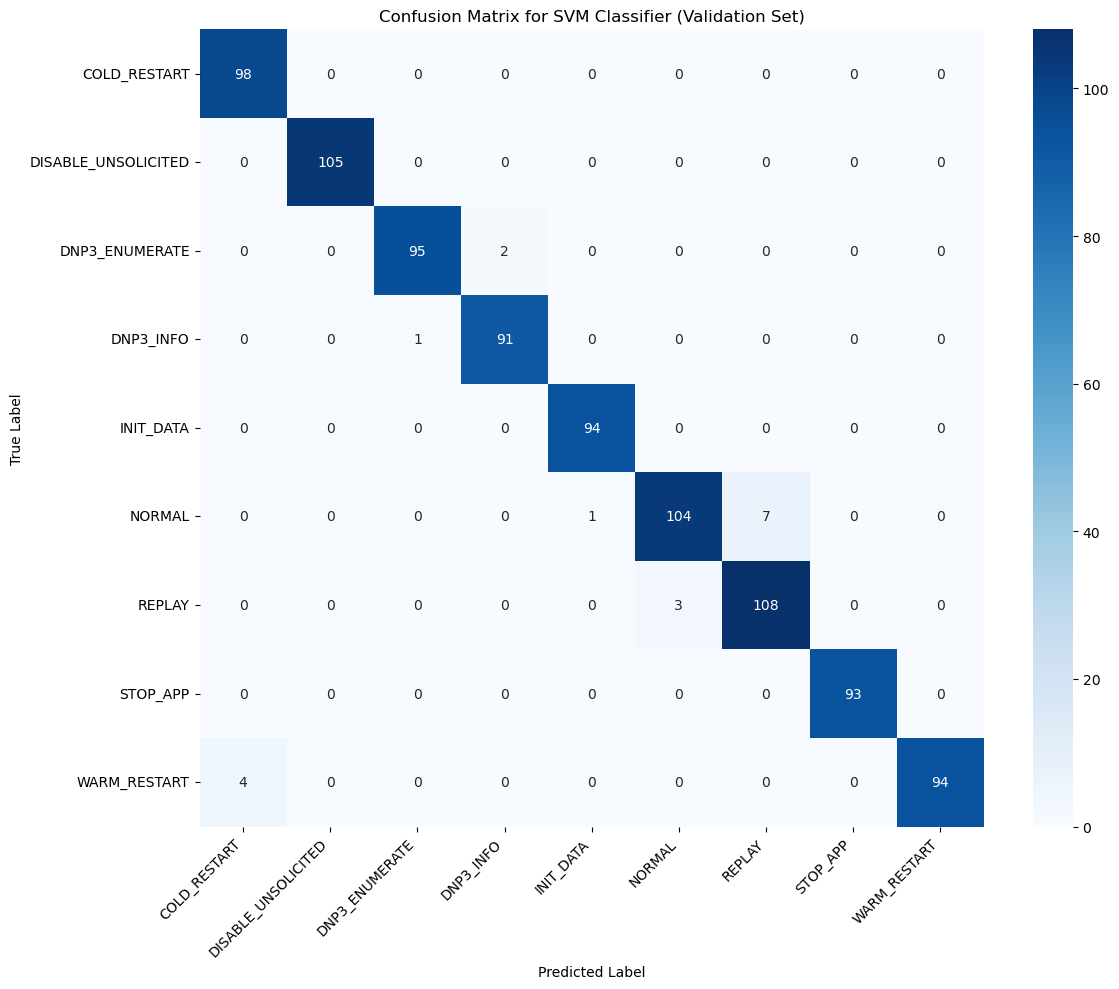

In [30]:
print("\n--- Evaluating Best Model on Validation Set ---")
y_pred_val = best_svm.predict(X_val)

label_encoder = fit_objects['label_encoder']
try:
    y_pred_val_labels = label_encoder.inverse_transform(y_pred_val)
    y_val_labels = label_encoder.inverse_transform(y_val)
    target_names_val = label_encoder.classes_
except Exception as e:
    print(f"Error inverse transforming validation labels: {e}")
    print("Using encoded labels for validation reporting.")
    y_pred_val_labels = y_pred_val
    y_val_labels = y_val
    target_names_val = [str(cls) for cls in label_encoder.classes_]

accuracy_val = accuracy_score(y_val_labels, y_pred_val_labels)
print(f"Validation Set Accuracy: {accuracy_val:.4f}")
print("\nValidation Set Classification Report:")
print(classification_report(y_val_labels, y_pred_val_labels, target_names=target_names_val))

print("\nGenerating Validation Set Confusion Matrix...")
plot_confusion_matrix(y_val_labels, y_pred_val_labels, target_names_val, "Confusion Matrix for SVM Classifier (Validation Set)")


--- Evaluating Best Model on Test Set ---
Test Set Accuracy: 0.9900

Test Set Classification Report:
                     precision    recall  f1-score   support

       COLD_RESTART       0.94      1.00      0.97       102
DISABLE_UNSOLICITED       1.00      1.00      1.00        95
     DNP3_ENUMERATE       1.00      1.00      1.00       103
          DNP3_INFO       1.00      1.00      1.00       108
          INIT_DATA       0.99      1.00      1.00       106
             NORMAL       0.99      0.98      0.98        88
             REPLAY       0.99      0.99      0.99        89
           STOP_APP       1.00      1.00      1.00       107
       WARM_RESTART       1.00      0.94      0.97       102

           accuracy                           0.99       900
          macro avg       0.99      0.99      0.99       900
       weighted avg       0.99      0.99      0.99       900


Generating Test Set Confusion Matrix...


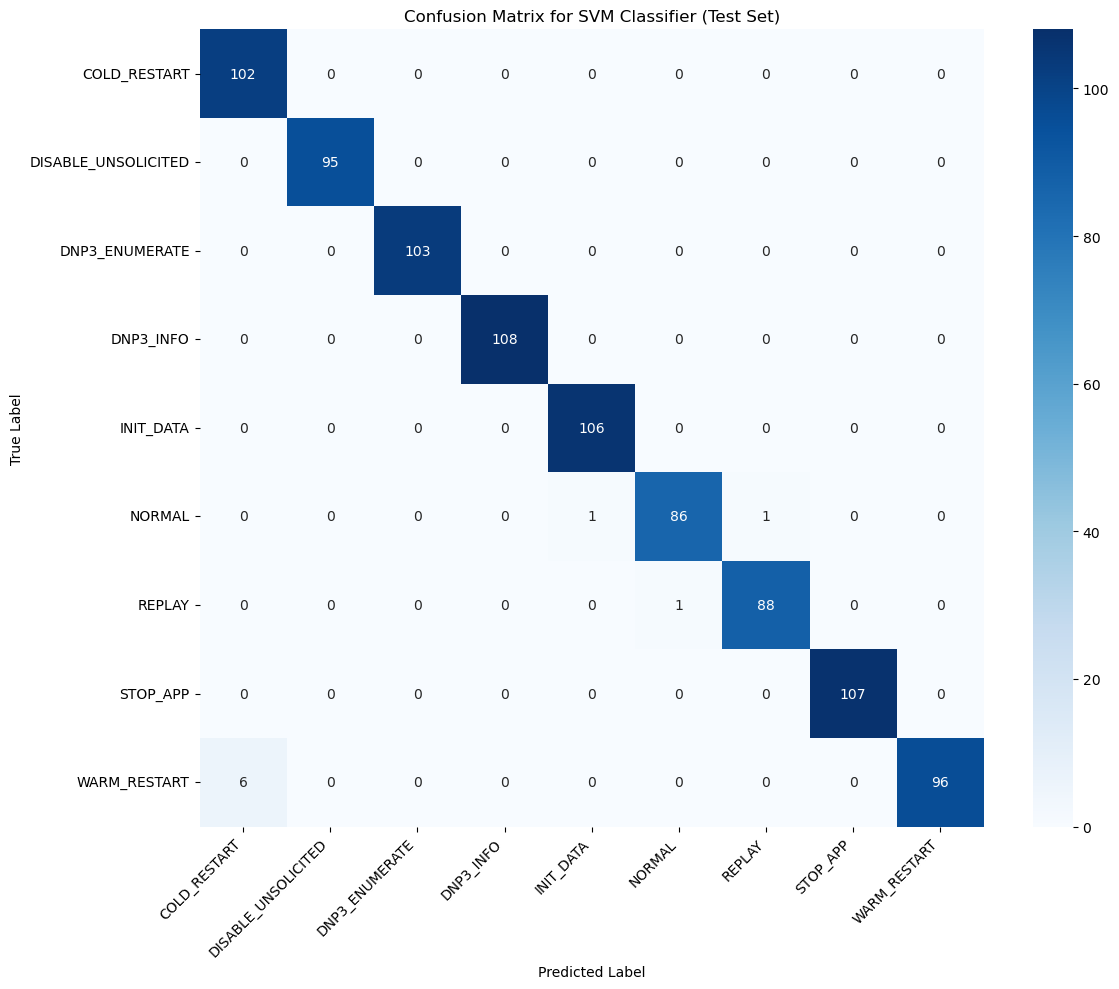

In [31]:
print("\n--- Evaluating Best Model on Test Set ---")
y_pred_test = best_svm.predict(X_test)

try:
    y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
    y_test_labels = label_encoder.inverse_transform(y_test)
    target_names_test = label_encoder.classes_
except Exception as e:
    print(f"Error inverse transforming test labels: {e}")
    print("Using encoded labels for test reporting.")
    y_pred_test_labels = y_pred_test
    y_test_labels = y_test
    target_names_test = [str(cls) for cls in label_encoder.classes_]

accuracy_test = accuracy_score(y_test_labels, y_pred_test_labels)
print(f"Test Set Accuracy: {accuracy_test:.4f}")
print("\nTest Set Classification Report:")
print(classification_report(y_test_labels, y_pred_test_labels, target_names=target_names_test))

print("\nGenerating Test Set Confusion Matrix...")
plot_confusion_matrix(y_test_labels, y_pred_test_labels, target_names_test, "Confusion Matrix for SVM Classifier (Test Set)")

In [32]:
# --- 7. Save Test Predictions ---
print("\n--- Saving Test Set Predictions ---")
try:
    # Use the potentially readable labels if inverse transform succeeded
    svm_predictions = pd.DataFrame({'Predicted_SVM': y_pred_test_labels,
                                    'Actual': y_test_labels},
                                   index=test_data.index) # Keep original index if possible
    output_filename = "svm_predictions_final_test_set.csv"
    svm_predictions.to_csv(output_filename, index_label='OriginalIndex')
    print(f"Test predictions saved to {output_filename}")
except Exception as e:
    print(f"Error saving predictions: {e}")
    print("Attempting to save with encoded labels as fallback.")
    try:
        svm_predictions_encoded = pd.DataFrame({'Predicted_SVM_Encoded': y_pred_test,
                                                'Actual_Encoded': y_test},
                                               index=test_data.index)
        output_filename_enc = "svm_predictions_final_test_set_encoded.csv"
        svm_predictions_encoded.to_csv(output_filename_enc, index_label='OriginalIndex')
        print(f"Test predictions (encoded) saved to {output_filename_enc}")
    except Exception as e_enc:
        print(f"Could not save encoded predictions either: {e_enc}")

print("\n--- Script Finished ---")


--- Saving Test Set Predictions ---
Test predictions saved to svm_predictions_final_test_set.csv

--- Script Finished ---



--- Generating Results Dashboard ---


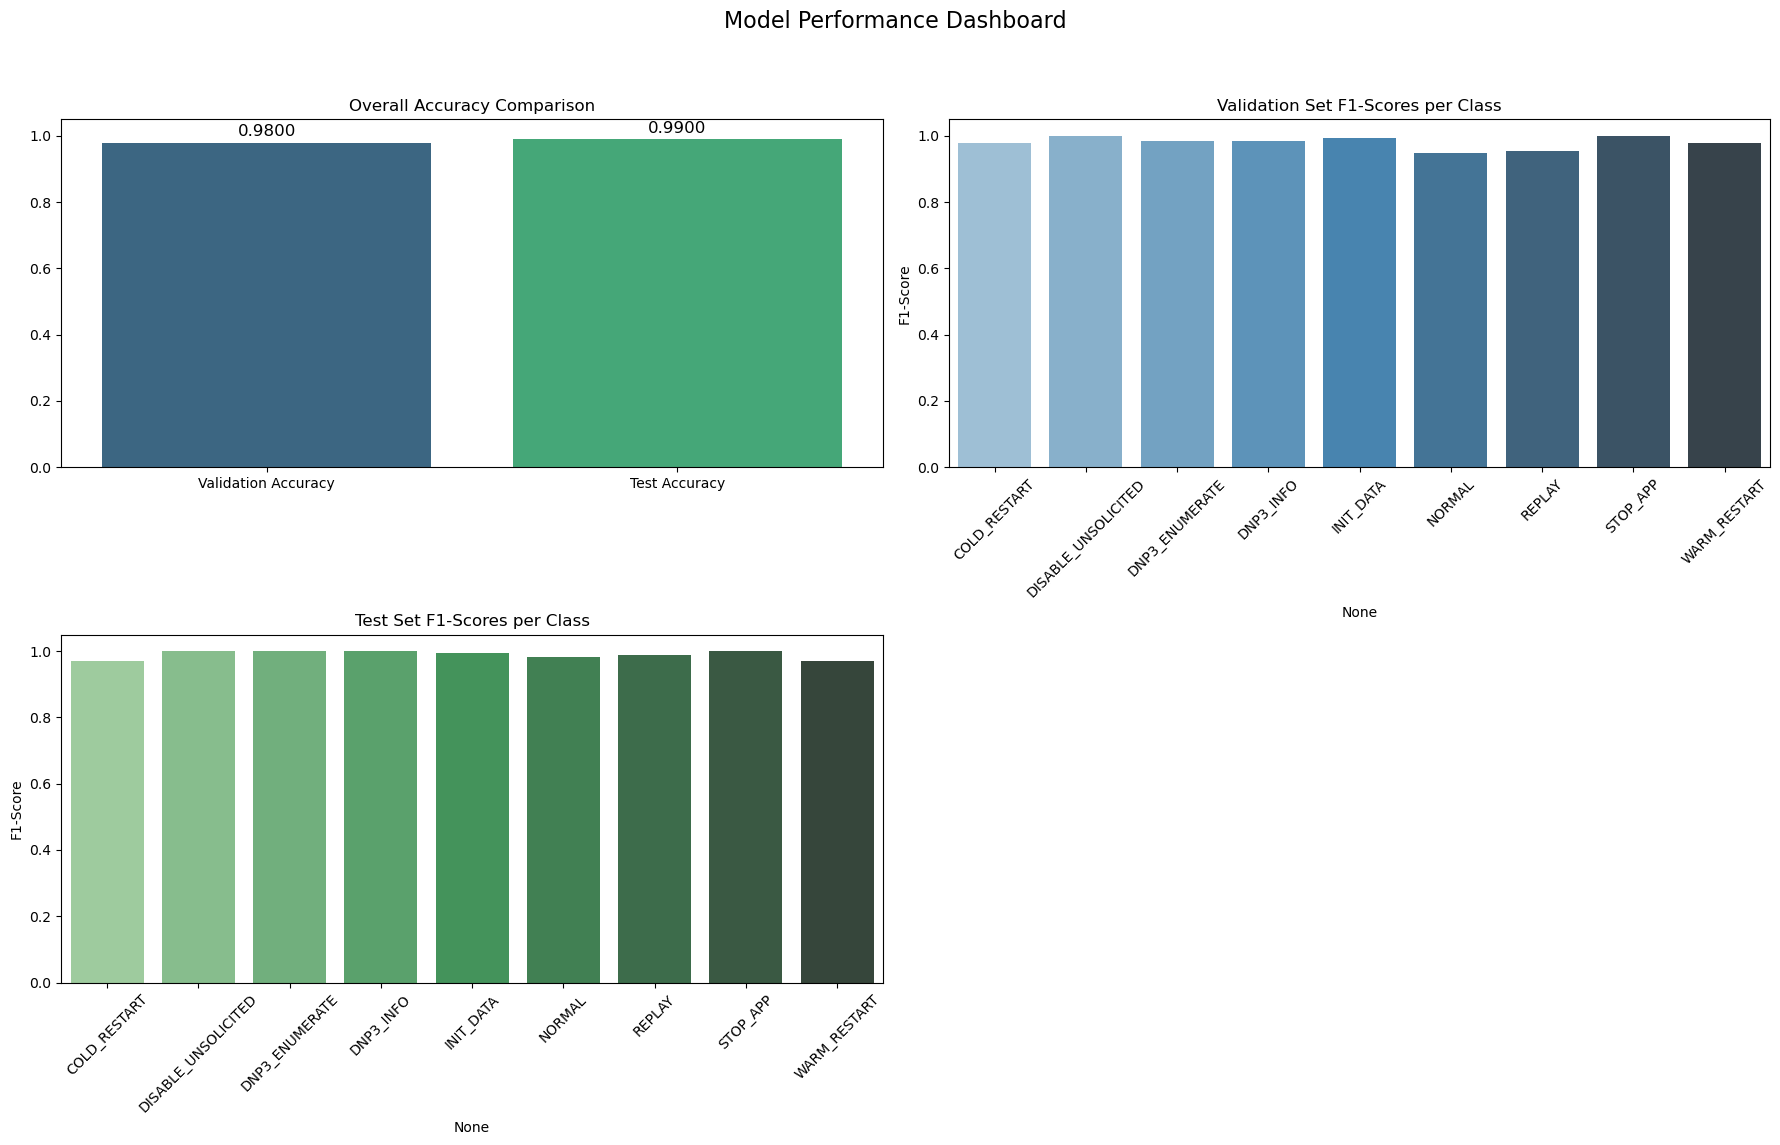

In [33]:
print("\n--- Generating Results Dashboard ---")

report_val_dict = classification_report(y_val_labels, y_pred_val_labels, target_names=target_names_val, output_dict=True)
report_test_dict = classification_report(y_test_labels, y_pred_test_labels, target_names=target_names_test, output_dict=True)

df_report_val = pd.DataFrame(report_val_dict).transpose()
df_report_test = pd.DataFrame(report_test_dict).transpose()

class_names = [name for name in target_names_val if name in df_report_val.index]

f1_val = df_report_val.loc[class_names, 'f1-score']
f1_test = df_report_test.loc[class_names, 'f1-score']


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('Model Performance Dashboard', fontsize=16)

ax1 = axes[0, 0]
accuracies = [accuracy_val, accuracy_test]
acc_labels = ['Validation Accuracy', 'Test Accuracy']
sns.barplot(x=acc_labels, y=accuracies, ax=ax1, palette='viridis')
ax1.set_title('Overall Accuracy Comparison')
ax1.set_ylim(0, 1.05)
for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

ax2 = axes[0, 1]
sns.barplot(x=f1_val.index, y=f1_val.values, ax=ax2, palette='Blues_d')
ax2.set_title('Validation Set F1-Scores per Class')
ax2.set_ylabel('F1-Score')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='x', rotation=45)

ax3 = axes[1, 0]
sns.barplot(x=f1_test.index, y=f1_test.values, ax=ax3, palette='Greens_d')
ax3.set_title('Test Set F1-Scores per Class')
ax3.set_ylabel('F1-Score')
ax3.set_ylim(0, 1.05)
ax3.tick_params(axis='x', rotation=45)

fig.delaxes(axes[1, 1])
ax4 = axes[1, 1]
ax4.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [34]:
print("\n--- Saving Test Set Predictions ---")
try:
    svm_predictions = pd.DataFrame({'Predicted_SVM': y_pred_test_labels,
                                    'Actual': y_test_labels},
                                   index=test_data.index)
    output_filename = "svm_predictions_final_test_set.csv"
    svm_predictions.to_csv(output_filename, index_label='OriginalIndex')
    print(f"Test predictions saved to {output_filename}")
except Exception as e:
    print(f"Error saving predictions: {e}")
    print("Attempting to save with encoded labels as fallback.")
    try:
        svm_predictions_encoded = pd.DataFrame({'Predicted_SVM_Encoded': y_pred_test,
                                                'Actual_Encoded': y_test},
                                               index=test_data.index)
        output_filename_enc = "svm_predictions_final_test_set_encoded.csv"
        svm_predictions_encoded.to_csv(output_filename_enc, index_label='OriginalIndex')
        print(f"Test predictions (encoded) saved to {output_filename_enc}")
    except Exception as e_enc:
        print(f"Could not save encoded predictions either: {e_enc}")


--- Saving Test Set Predictions ---
Test predictions saved to svm_predictions_final_test_set.csv


In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Load the datasets (Ensure you have correct filepaths)
train_data = pd.read_csv("/kaggle/input/dnp3-training/Custom_DNP3_Parser_Training_Balanced.csv")
train_data.columns = train_data.columns.str.strip()
test_data = pd.read_csv("/kaggle/input/dnp3-testing/Custom_DNP3_Parser_Testing_Balanced.csv")
test_data.columns = test_data.columns.str.strip()
# model_testing = pd.read_csv("/kaggle/input/model-testing/Model_Testing_dataset.csv")
# model_testing.columns = model_testing.columns.str.strip()
cold_restart = pd.read_csv("/kaggle/input/dnp3-cold-restart-120to-s1/20200515_Cold_Restart_Attack_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv")
cold_restart.columns = cold_restart.columns.str.strip()
cold_restart_s2 = pd.read_csv("/kaggle/input/dnp3-cold-restart-120ts-s2/20200515_Cold_Restart_Attack_UOWM_DNP3_Dataset_Slave_02.pcapDNP3_FLOWLABELED.csv")
cold_restart_s2.columns = cold_restart_s2.columns.str.strip()
warm_restart = pd.read_csv("/kaggle/input/dnp3-warm-restart-120to-s1/20200515_DNP3_Warm_Restart_Attack_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv")
warm_restart.columns = warm_restart.columns.str.strip()
Enum = pd.read_csv("/kaggle/input/dnp3-enum-120to-s1/20200516_DNP3_Enumerate_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv")
Enum.columns = Enum.columns.str.strip()
info = pd.read_csv("/kaggle/input/dnp3-info-120to-s1/20200516_DNP3_info_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv")
info.columns = info.columns.str.strip()


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dnp3-cold-restart-120ts-s2/20200515_Cold_Restart_Attack_UOWM_DNP3_Dataset_Slave_02.pcapDNP3_FLOWLABELED.csv
/kaggle/input/dnp3-enum-120to-s1/20200516_DNP3_Enumerate_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv
/kaggle/input/dnp3-warm-restart-120to-s1/20200515_DNP3_Warm_Restart_Attack_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv
/kaggle/input/dnp3-training/Custom_DNP3_Parser_Training_Balanced.csv
/kaggle/input/dnp3-testing/Custom_DNP3_Parser_Testing_Balanced.csv
/kaggle/input/dnp3-cold-restart-120to-s1/20200515_Cold_Restart_Attack_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv
/kaggle/input/dnp3-cold-restart-s1/20200515_DNP3_Cold_Restart_Attack_UOWM_DNP3_Dataset_Slave_01.pcap_FlowLABELED.csv
/kaggle/input/dnp3-info-120to-s1/20200516_DNP3_info_UOWM_DNP3_Dataset_Slave_01.pcapDNP3_FLOWLABELED.csv


In [133]:
# Get the column names
train_columns = set(train_data.columns)
info_columns = set(info.columns)

# Find columns that are in train_data but not in cold_restart
only_in_train = train_columns - cold_restart_columns

# Find columns that are in cold_restart but not in train_data
only_in_cold_restart = cold_restart_columns - train_columns

# Print the results
print("Columns in train_data but not in cold_restart:", only_in_train)
print("Columns in cold_restart but not in train_data:", only_in_cold_restart)

Columns in train_data but not in cold_restart: {'Unnamed: 0', 'date', 'destination IP', 'flow ID', 'Label', 'Unnamed: 0.1', 'source IP'}
Columns in cold_restart but not in train_data: {'is_hack'}


In [134]:
def create_binary_labels(labels):
    """Maps the detailed attack labels to a binary 1 (Hack) or 0 (No Hack)."""
    hack_labels = ['REPLAY', 'COLD_RESTART', 'WARM_RESTART', 'DISABLE_UNSOLICITED', 'STOP_APP',
                   'DNP3_ENUMERATE', 'DNP3_INFO', 'INIT_DATA']  # List all the attack types
    return [1 if label in hack_labels else 0 for label in labels]


In [135]:
def preprocess_data(df, is_training=True, training_columns=None, remove_correlated=False, pca_components=None, pca=None):
    """Preprocesses the data, including creation of binary 'is_hack' target."""

    # Drop specified columns
    columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'flow ID', 'source IP', 'destination IP', 'date', 'Label']#, 'Timestamp', 'Flow ID', 'Src IP', 'Dst IP']  # Drop 'Label'

    # Add this
    df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

    # Convert 'firstPacketDIR' to numerical
    if 'firstPacketDIR' in df.columns:
        df['firstPacketDIR'] = df['firstPacketDIR'].map({'MASTER': 0, 'OUTSTATION': 1}).fillna(-1)

    # Convert to numeric, coercing errors to NaN
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Impute missing values (NaNs)
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns) #Applies imputer to all as "Labels" have been removed

    # Scaling numerical features
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return df


In [136]:
def visualize_classification_report(report, title="Classification Report", ax=None):
    """Visualizes a classification report using a heatmap."""
    data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = line.strip().split()
        if len(row) < 4:  # Check for sufficient number of columns, change 4 based on result needs
            continue # Skip this interation since it is not needed
        row_data = {}
        row_data['class'] = row[0] # was row_data['class'] = row[0] before
        #Error Handling
        try:
            row_data['precision'] = float(row[1])
            row_data['recall'] = float(row[2])
            row_data['f1_score'] = float(row[3])
        except ValueError: #Catch for when row[1], row[2], or row[3] does not exist
            print("Skipping row due to formatting issues.")
            continue # continue this since these has an issues and needs to have data

        data.append(row_data)
    df = pd.DataFrame.from_records(data, index='class')
    sns.heatmap(df[['precision', 'recall', 'f1_score']], annot=True, cmap="YlGnBu", ax=ax, fmt=".2f")
    ax.set_title(title)

In [137]:
# Load data & Create Labels
train_data['Label'] = train_data['Label'].astype('object')
test_data['Label'] = test_data['Label'].astype('object')
# model_testing['Label'] = model_testing['Label'].astype('object')
cold_restart['Label'] = cold_restart['Label'].astype('object')
cold_restart_s2['Label'] = cold_restart_s2['Label'].astype('object')
warm_restart['Label'] = warm_restart['Label'].astype('object')
Enum['Label'] = Enum['Label'].astype('object')
info['Label'] = info['Label'].astype('object')

In [138]:
# Create binary labels and add to DataFrame BEFORE preprocessing
train_data['is_hack'] = create_binary_labels(train_data['Label'])
test_data['is_hack'] = create_binary_labels(test_data['Label'])
# model_testing['is_hack'] = create_binary_labels(model_testing['Label'])
cold_restart['is_hack'] = create_binary_labels(cold_restart['Label'])
cold_restart_s2['is_hack'] = create_binary_labels(cold_restart_s2['Label'])
warm_restart['is_hack'] = create_binary_labels(warm_restart['Label'])
Enum['is_hack'] = create_binary_labels(Enum['Label'])
info['is_hack'] = create_binary_labels(info['Label'])

In [141]:
# Preprocess Data, now with binary labels
X_train = preprocess_data(train_data, is_training=True)
X_test = preprocess_data(test_data, is_training=False)
# X_model_testing = preprocess_data(model_testing, is_training=False)
X_cold_restart = preprocess_data(cold_restart, is_training=False)
X_cold_restart_s2 = preprocess_data(cold_restart_s2, is_training=False)
X_warm_restart = preprocess_data(warm_restart, is_training=False)
X_Enum = preprocess_data(Enum, is_training=False)
X_info = preprocess_data(info, is_training=False)

In [142]:
# Set the variables
y_train = train_data['is_hack']
y_test =  test_data['is_hack']
# y_model_testing = model_testing['is_hack']
y_cold_restart = cold_restart['is_hack']
y_cold_restart_s2 = cold_restart_s2['is_hack']
y_warm_restart = warm_restart['is_hack']
y_Enum = Enum['is_hack']
y_info = info['is_hack']

In [143]:
# --- PCA ---
pca = PCA(n_components=10)
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))
# X_model_testing = pd.DataFrame(pca.transform(X_model_testing))
X_cold_restart = pd.DataFrame(pca.transform(X_cold_restart))
X_cold_restart_s2 = pd.DataFrame(pca.transform(X_cold_restart_s2))
X_warm_restart = pd.DataFrame(pca.transform(X_warm_restart))
X_Enum = pd.DataFrame(pca.transform(X_Enum))
X_info = pd.DataFrame(pca.transform(X_info))



# --- Model Training and Evaluation ---
svm_model = make_pipeline(MinMaxScaler(), SVC(random_state=42))

# Model Training
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)
# model_test_Predict = svm_model.predict(X_model_testing)
cold_restart_Predict = svm_model.predict(X_cold_restart)
cold_restart_Predict_s2 = svm_model.predict(X_cold_restart_s2)
warm_restart_predict = svm_model.predict(X_warm_restart)
Enum_predict = svm_model.predict(X_Enum)
info_predict = svm_model.predict(X_info)

Accuracy: 1.0000
Classification Report (Hack vs. No Hack):
Skipping row due to formatting issues.


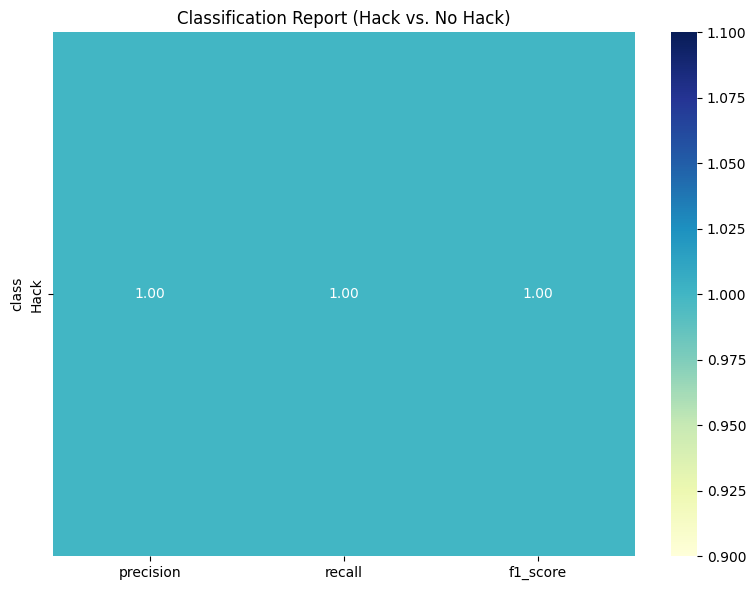

In [144]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report (Hack vs. No Hack):")
report = classification_report(y_test, y_pred, target_names=['No Hack', 'Hack'])# Target names will replace 0 and 1

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))
visualize_classification_report(report, title="Classification Report (Hack vs. No Hack)", ax=ax)
plt.tight_layout()
plt.show()

Accuracy: 0.7521
Classification Report (Hack vs. No Hack):
Skipping row due to formatting issues.


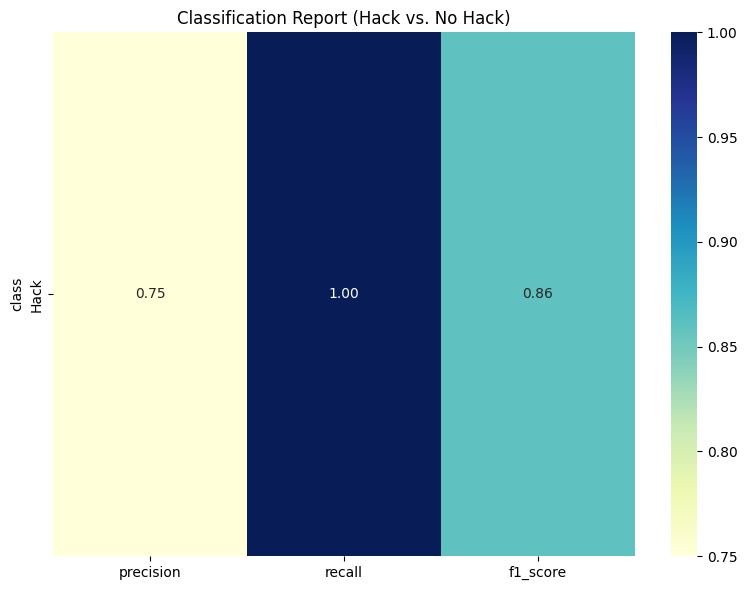

In [145]:
# Evaluate
accuracy = accuracy_score(y_cold_restart, cold_restart_Predict)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report (Hack vs. No Hack):")
report = classification_report(y_cold_restart, cold_restart_Predict, target_names=['No Hack', 'Hack'])# Target names will replace 0 and 1

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))
visualize_classification_report(report, title="Classification Report (Hack vs. No Hack)", ax=ax)
plt.tight_layout()
plt.show()

Accuracy: 0.7583
Classification Report (Hack vs. No Hack):
Skipping row due to formatting issues.


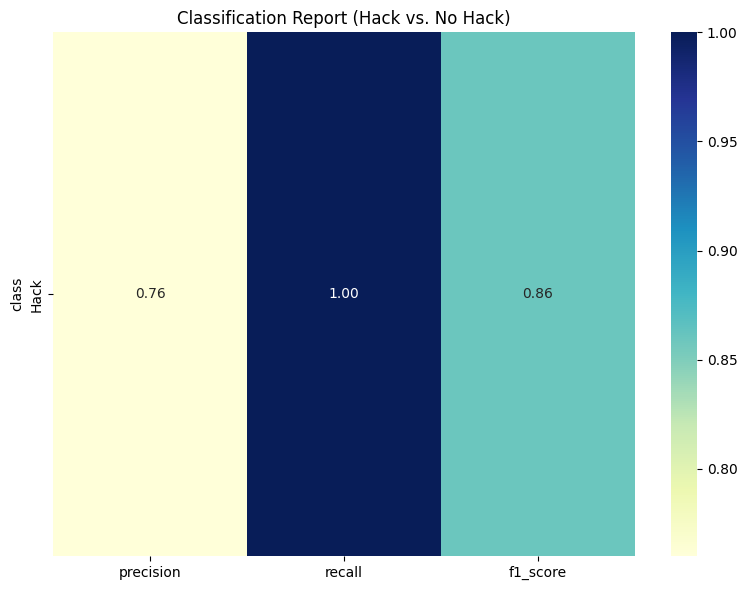

In [146]:
# Evaluate
accuracy = accuracy_score(y_cold_restart_s2, cold_restart_Predict_s2)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report (Hack vs. No Hack):")
report = classification_report(y_cold_restart_s2, cold_restart_Predict_s2, target_names=['No Hack', 'Hack'])# Target names will replace 0 and 1

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))
visualize_classification_report(report, title="Classification Report (Hack vs. No Hack)", ax=ax)
plt.tight_layout()
plt.show()

Accuracy: 0.9979
Classification Report (Hack vs. No Hack):
Skipping row due to formatting issues.


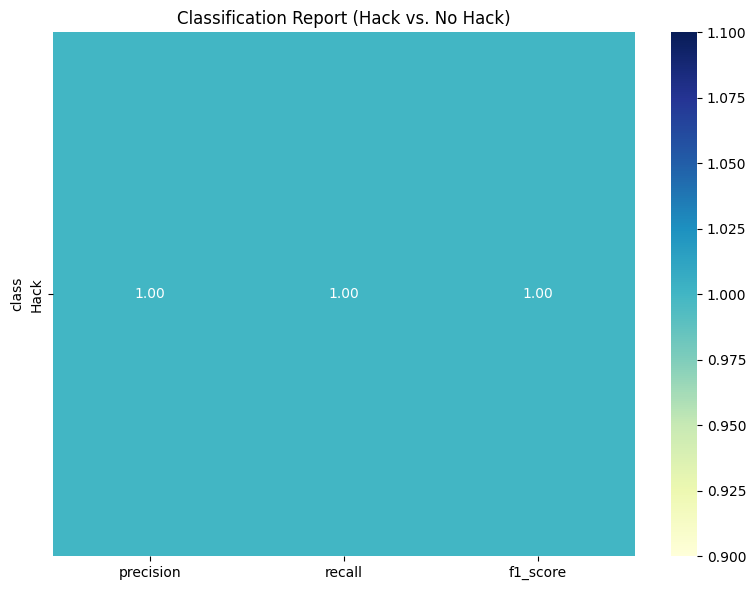

In [148]:
# Evaluate
accuracy = accuracy_score(y_warm_restart, warm_restart_predict)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report (Hack vs. No Hack):")
report = classification_report(y_warm_restart, warm_restart_predict, target_names=['No Hack', 'Hack'])# Target names will replace 0 and 1

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))
visualize_classification_report(report, title="Classification Report (Hack vs. No Hack)", ax=ax)
plt.tight_layout()
plt.show()

Accuracy: 0.7418
Classification Report (Hack vs. No Hack):
Skipping row due to formatting issues.


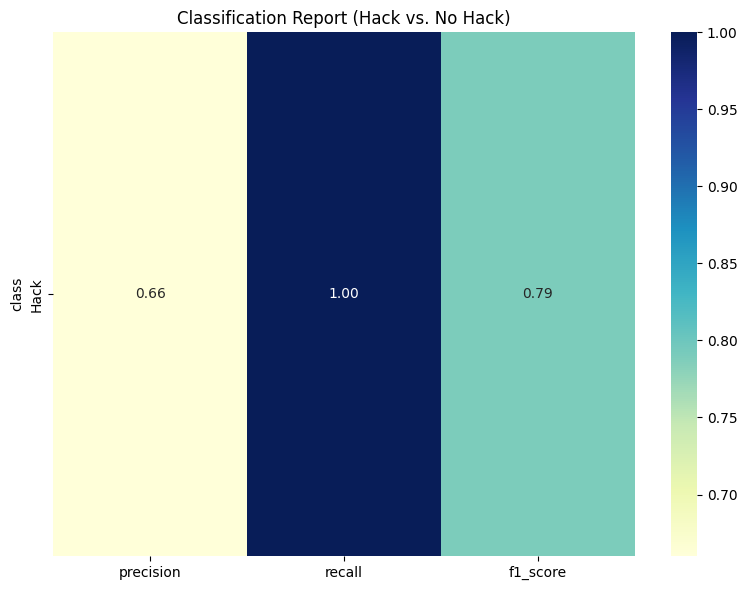

In [149]:
# Evaluate
accuracy = accuracy_score(y_Enum, Enum_predict)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report (Hack vs. No Hack):")
report = classification_report(y_Enum, Enum_predict, target_names=['No Hack', 'Hack'])# Target names will replace 0 and 1

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))
visualize_classification_report(report, title="Classification Report (Hack vs. No Hack)", ax=ax)
plt.tight_layout()
plt.show()

Accuracy: 0.4996
Classification Report (Hack vs. No Hack):
Skipping row due to formatting issues.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


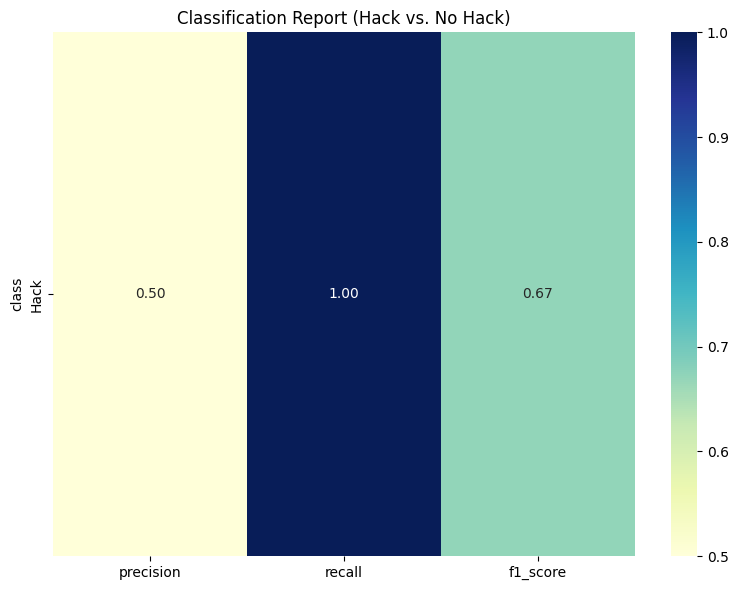

In [150]:
# Evaluate
accuracy = accuracy_score(y_info, info_predict)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report (Hack vs. No Hack):")
report = classification_report(y_info, info_predict, target_names=['No Hack', 'Hack'])# Target names will replace 0 and 1

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))
visualize_classification_report(report, title="Classification Report (Hack vs. No Hack)", ax=ax)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Pipeline is removed as preprocessing is self-contained now
from sklearn.impute import SimpleImputer # For handling missing values robustly
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings


In [2]:

warnings.filterwarnings('ignore', category=FutureWarning) # Suppress some numpy warnings
warnings.filterwarnings('ignore', category=UserWarning) # Suppress the date parsing warning after fixing it

# --- Configuration ---
PCA_N_COMPONENTS = 10 # Set number of PCA components (or None to disable PCA)
# Reduced grid for faster example run, expand as needed
SVM_C_VALUES = [0.1, 1, 10, 50]
SVM_GAMMA_VALUES = ['scale', 'auto', 0.1]
SVM_KERNEL_VALUES = ['rbf', 'linear']
CV_FOLDS = 5 # Cross-validation folds for GridSearchCV

# --- Load Data ---
print("Loading data...")
try:
    train_data = pd.read_csv("/kaggle/input/dnp3-training/Custom_DNP3_Parser_Training_Balanced.csv")
    test_data = pd.read_csv("/kaggle/input/dnp3-testing/Custom_DNP3_Parser_Testing_Balanced.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure the input files are correctly placed in /kaggle/input/...")
    exit()

# List input files for verification
print("\nFiles in input directory:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("-" * 30)


# --- Feature Engineering and Preprocessing Function ---
def preprocess_data(df, is_training=True, fit_objects=None):
    """
    Preprocesses the data:
    - Cleans column names.
    - Engineers features from 'date', 'source IP', 'destination IP', 'flow ID'.
    - Handles 'firstPacketDIR'.
    - Converts columns to numeric, handles all-NaN columns, imputes missing values.
    - Applies Label Encoding to the target variable.
    - Optionally applies PCA.
    - Returns preprocessed features (X), target (y), and fitted objects.
    """
    print(f"\nPreprocessing {'Training' if is_training else 'Testing'} Data...")
    df = df.copy() # Work on a copy to avoid modifying the original dataframe

    # Clean column names
    df.columns = df.columns.str.strip()

    # Store or retrieve fitted objects (LabelEncoder, Imputer, Scaler, PCA, Frequency Maps)
    if is_training:
        fit_objects = {'label_encoder': LabelEncoder(),
                       'imputer': SimpleImputer(strategy='median'),
                       'scaler': StandardScaler(),
                       'pca': PCA(n_components=PCA_N_COMPONENTS) if PCA_N_COMPONENTS else None,
                       'ip_freq_maps': {},
                       'dropped_all_nan_cols': []} # Keep track of dropped columns
    elif fit_objects is None:
        raise ValueError("fit_objects dictionary must be provided for test data preprocessing.")
    # --- Feature Engineering ---

    # 1. Date Features
    if 'date' in df.columns:
        print("Engineering Date Features...")
        try:
            # *** FIX: Add dayfirst=True ***
            df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
            df['hour'] = df['date'].dt.hour
            df['minute'] = df['date'].dt.minute
            df['second'] = df['date'].dt.second
            df['dayofweek'] = df['date'].dt.dayofweek
            df.drop('date', axis=1, inplace=True)
             # Impute NaNs that might arise from coercion or original NaNs in time features
            time_cols = ['hour', 'minute', 'second', 'dayofweek']
            for col in time_cols:
                 # Check if column exists before filling NAs
                 if col in df.columns:
                     df[col].fillna(df[col].median(), inplace=True)
        except Exception as e:
            print(f"Error processing 'date' column: {e}. Skipping date features.")
            if 'date' in df.columns: # Drop if it exists but caused error
                 df.drop('date', axis=1, inplace=True)
    else:
        print("Warning: 'date' column not found.")

    # 2. IP Address Frequency Encoding
    for col in ['source IP', 'destination IP']:
        if col in df.columns:
            print(f"Encoding '{col}' Frequency...")
            map_name = f"{col}_freq_map"
            if is_training:
                freq_map = df[col].value_counts().to_dict()
                fit_objects['ip_freq_maps'][map_name] = freq_map
                df[col + '_freq'] = df[col].map(freq_map)
                # Impute NaNs created by mapping (if any, though unlikely with value_counts)
                df[col + '_freq'].fillna(0, inplace=True)
            else:
                freq_map = fit_objects['ip_freq_maps'].get(map_name, {})
                df[col + '_freq'] = df[col].map(freq_map)
                df[col + '_freq'].fillna(0, inplace=True) # Handle IPs unseen in training & original NaNs
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Warning: '{col}' column not found.")

    # 3. Flow ID Conversion (Attempt numeric conversion)
    if 'flow ID' in df.columns:
        print("Converting 'flow ID'...")
        df['flow ID_numeric'] = pd.to_numeric(df['flow ID'], errors='coerce')
        # Don't impute here yet, let the main imputer handle it after checking for all-NaN
        df.drop('flow ID', axis=1, inplace=True)
    else:
        print("Warning: 'flow ID' column not found.")

    # 4. Handle 'firstPacketDIR'
    if 'firstPacketDIR' in df.columns:
        print("Mapping 'firstPacketDIR'...")
        df['firstPacketDIR'] = df['firstPacketDIR'].map({'MASTER': 0, 'OUTSTATION': 1})
        df['firstPacketDIR'].fillna(-1, inplace=True)
    else:
         print("Warning: 'firstPacketDIR' column not found.")

    # Drop other non-feature columns (do this *after* feature engineering)
    columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')

    # Separate Target Variable (Label)
    if 'Label' in df.columns:
        print("Processing Target Variable 'Label'...")
        y = df['Label']
        X = df.drop('Label', axis=1)
        y = y.fillna('Unknown')
        print("Unique values in Label column:", y.unique())

        if is_training:
            y_encoded = fit_objects['label_encoder'].fit_transform(y)
        else:
            le = fit_objects['label_encoder']
            seen_labels = set(le.classes_)
            current_labels = set(y.unique())
            unseen_labels = current_labels - seen_labels
            if unseen_labels:
                 print(f"Warning: Found unseen labels in test data: {unseen_labels}. Mapping them to a placeholder class index if possible or handling error.")
                 # Add unseen labels dynamically ONLY if necessary and strategy is defined
                 # For simplicity here, we'll filter out test rows with unseen labels if needed, or map to -1
                 # A safer approach: Map unseen labels to a specific known category like 'Unknown' if it exists in training encoder
                 if 'Unknown' in le.classes_:
                      unknown_class_index = list(le.classes_).index('Unknown')
                      y = y.apply(lambda x: x if x in seen_labels else 'Unknown')
                      y_encoded = le.transform(y)
                 else:
                      # If 'Unknown' wasn't trained on, we have to decide: error out, or map to a dummy index?
                      # Let's try transforming and let it error if truly unseen and no fallback exists.
                      print("Attempting transform, may error on unseen labels if 'Unknown' not trained.")
                      y_encoded = le.transform(y) # This might error now if unseen remain and 'Unknown' not trained on
            else:
                 y_encoded = le.transform(y)

    else:
        print("Warning: 'Label' column not found. Assuming data is features only (X).")
        X = df
        y_encoded = None

    # --- Numeric Conversion, Handle All-NaN, Imputation, Scaling, PCA ---

    # Ensure all feature columns are numeric before imputation/scaling
    print("Converting feature columns to numeric...")
    feature_cols = X.columns.tolist()
    for col in feature_cols:
        if col in X.columns and X[col].dtype == 'object':
             X[col] = pd.to_numeric(X[col], errors='coerce')

    # *** FIX: Identify and handle columns that are entirely NaN ***
    if is_training:
        all_nan_cols = X.columns[X.isna().all()].tolist()
        if all_nan_cols:
            print(f"Warning: The following columns are entirely NaN after coercion: {all_nan_cols}")
            print("Dropping these columns before imputation.")
            X = X.drop(columns=all_nan_cols)
            fit_objects['dropped_all_nan_cols'] = all_nan_cols # Store dropped cols
            print(f"Shape of X after dropping all-NaN columns: {X.shape}")
        else:
            fit_objects['dropped_all_nan_cols'] = []
    else:
        # Drop the same columns in test data that were dropped in training
        cols_to_drop_test = fit_objects.get('dropped_all_nan_cols', [])
        if cols_to_drop_test:
             print(f"Dropping columns found to be all-NaN during training: {cols_to_drop_test}")
             # Ensure columns actually exist in X_test before trying to drop
             cols_to_drop_test = [col for col in cols_to_drop_test if col in X.columns]
             X = X.drop(columns=cols_to_drop_test)
             print(f"Shape of X after dropping corresponding all-NaN columns: {X.shape}")


    print(f"Features count before imputation: {X.shape[1]}")
    # print(f"Columns going into imputer: {X.columns.tolist()}") # Optional detailed print

    # Impute Remaining Missing Values (using median strategy)
    print("Imputing missing values...")
    if is_training:
        fit_objects['imputer'] = SimpleImputer(strategy='median') # Re-init in case columns changed
        X_imputed = fit_objects['imputer'].fit_transform(X)
    else:
        # Ensure imputer exists before transforming
        if 'imputer' not in fit_objects:
             raise RuntimeError("Imputer was not fitted during training.")
        X_imputed = fit_objects['imputer'].transform(X)

    # Convert back to DataFrame using the columns that went *into* the imputer
    # *** FIX: Use X.columns which now reflects any dropped all-NaN columns ***
    X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)


    # Scaling
    print("Scaling features...")
    if is_training:
        X_scaled = fit_objects['scaler'].fit_transform(X_imputed_df)
    else:
        X_scaled = fit_objects['scaler'].transform(X_imputed_df)
    # Convert back to DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_imputed_df.columns, index=X_imputed_df.index)


    # PCA (Optional)
    if fit_objects.get('pca'):
        print(f"Applying PCA (n_components={PCA_N_COMPONENTS})...")
        pca = fit_objects['pca']
        if is_training:
            X_processed = pca.fit_transform(X_scaled_df)
            explained_variance = np.sum(pca.explained_variance_ratio_)
            print(f"Explained variance with {pca.n_components_} components: {explained_variance:.4f}")
            fit_objects['pca_components'] = pca.n_components_ # Store actual components used
        else:
            X_processed = pca.transform(X_scaled_df)
        # Create meaningful column names for PCA features
        pca_cols = [f'PC_{i+1}' for i in range(X_processed.shape[1])]
        X_processed_df = pd.DataFrame(X_processed, columns=pca_cols, index=X_scaled_df.index)
    else:
        print("Skipping PCA.")
        X_processed_df = X_scaled_df # Use scaled data if PCA is disabled

    # Store final column names/order from training, ensure test matches
    if is_training:
         fit_objects['final_columns'] = X_processed_df.columns.tolist()
    else:
         final_columns = fit_objects.get('final_columns')
         if final_columns:
              # Reindex test data to match training columns exactly
              # Add missing columns (fill with 0, though ideally imputer/scaler handle this)
              # Remove extra columns
              X_processed_df = X_processed_df.reindex(columns=final_columns, fill_value=0)
         else:
             print("Warning: 'final_columns' not found in fit_objects. Column alignment might fail.")


    print(f"Preprocessing complete. Final feature shape: {X_processed_df.shape}")

    if is_training:
        return X_processed_df, y_encoded, fit_objects
    else:
        return X_processed_df, y_encoded, None # Don't return fit_objects for test

Loading data...
Data loaded successfully.

Files in input directory:
/kaggle/input/dnp3-testing/Custom_DNP3_Parser_Testing_Balanced.csv
/kaggle/input/dnp3-training/Custom_DNP3_Parser_Training_Balanced.csv
------------------------------


In [3]:
# --- Main Execution ---

# Preprocess Training Data
X_train, y_train, fit_objects = preprocess_data(train_data, is_training=True)

# Preprocess Test Data using objects fitted on Training Data
X_test, y_test, _ = preprocess_data(test_data, is_training=False, fit_objects=fit_objects)

# --- Model Training and Evaluation ---

# Check if preprocessing resulted in valid data
if X_train is None or X_test is None or y_train is None or y_test is None:
    print("Error during preprocessing. Cannot proceed with model training.")
    exit()
if X_train.empty or X_test.empty:
    print("Error: Feature set is empty after preprocessing. Cannot train model.")
    exit()


print("\n--- Setting up SVM Model ---")
svm_model = SVC(random_state=255, probability=True) # Enable probability

# Define Parameter Grid for GridSearchCV
param_grid = {'C': SVM_C_VALUES,
              'gamma': SVM_GAMMA_VALUES,
              'kernel': SVM_KERNEL_VALUES
             }

print(f"Performing GridSearchCV (CV Folds = {CV_FOLDS})...")
print(f"Parameter Grid: {param_grid}")

# Use n_jobs=-1 for parallel processing if CPU cores available
grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, cv=CV_FOLDS, n_jobs=-1)

# Fit the grid search model
try:
    grid_search.fit(X_train, y_train)
except ValueError as e:
     print(f"\nError during GridSearchCV fit: {e}")
     print("This might happen if labels contain NaN or infinite values, or if data shapes mismatch.")
     print(f"y_train contains NaNs: {np.isnan(y_train).any()}")
     print(f"X_train contains NaNs after preprocessing: {X_train.isnull().values.any()}") # Should be False
     exit()


# --- Evaluate Best Model ---
best_svm = grid_search.best_estimator_
print("\n--- Evaluation Results ---")
print(f"Best Parameters found by GridSearchCV: {grid_search.best_params_}")
print(f"Best Model: {best_svm}")

# Make predictions on the test set
y_pred = best_svm.predict(X_test)

# Inverse transform predictions to original labels for reporting
label_encoder = fit_objects['label_encoder']
try:
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test) # Also transform y_test back
except ValueError as e:
    print(f"Error inverse transforming labels: {e}")
    # Handle cases where prediction might contain values not in original encoding
    # This might happen if the unseen label handling wasn't perfect
    print("Using encoded labels for reporting due to inverse_transform error.")
    y_pred_labels = y_pred # Fallback to encoded
    y_test_labels = y_test # Fallback to encoded
    target_names = [str(cls) for cls in label_encoder.classes_] # Use string representation of classes
else:
    # Get target names from the fitted label encoder if inverse_transform succeeded
    target_names = label_encoder.classes_


Preprocessing Training Data...
Engineering Date Features...
Encoding 'source IP' Frequency...
Encoding 'destination IP' Frequency...
Converting 'flow ID'...
Mapping 'firstPacketDIR'...
Processing Target Variable 'Label'...
Unique values in Label column: ['REPLAY' 'COLD_RESTART' 'DNP3_INFO' 'DNP3_ENUMERATE' 'WARM_RESTART'
 'DISABLE_UNSOLICITED' 'NORMAL' 'INIT_DATA' 'STOP_APP']
Converting feature columns to numeric...
Dropping these columns before imputation.
Shape of X after dropping all-NaN columns: (4194, 102)
Features count before imputation: 102
Imputing missing values...
Scaling features...
Applying PCA (n_components=10)...
Explained variance with 10 components: 0.9065
Preprocessing complete. Final feature shape: (4194, 10)

Preprocessing Testing Data...
Engineering Date Features...
Encoding 'source IP' Frequency...
Encoding 'destination IP' Frequency...
Converting 'flow ID'...
Mapping 'firstPacketDIR'...
Processing Target Variable 'Label'...
Unique values in Label column: ['WARM_


Test Set Accuracy: 0.9689

Classification Report:
                     precision    recall  f1-score   support

       COLD_RESTART       0.85      0.99      0.92       200
DISABLE_UNSOLICITED       1.00      1.00      1.00       200
     DNP3_ENUMERATE       0.98      0.97      0.97       200
          DNP3_INFO       0.97      0.99      0.98       200
          INIT_DATA       1.00      1.00      1.00       200
             NORMAL       1.00      0.95      0.98       200
             REPLAY       0.96      0.99      0.97       200
           STOP_APP       1.00      0.99      1.00       200
       WARM_RESTART       0.99      0.82      0.90       200

           accuracy                           0.97      1800
          macro avg       0.97      0.97      0.97      1800
       weighted avg       0.97      0.97      0.97      1800


Generating Confusion Matrix...


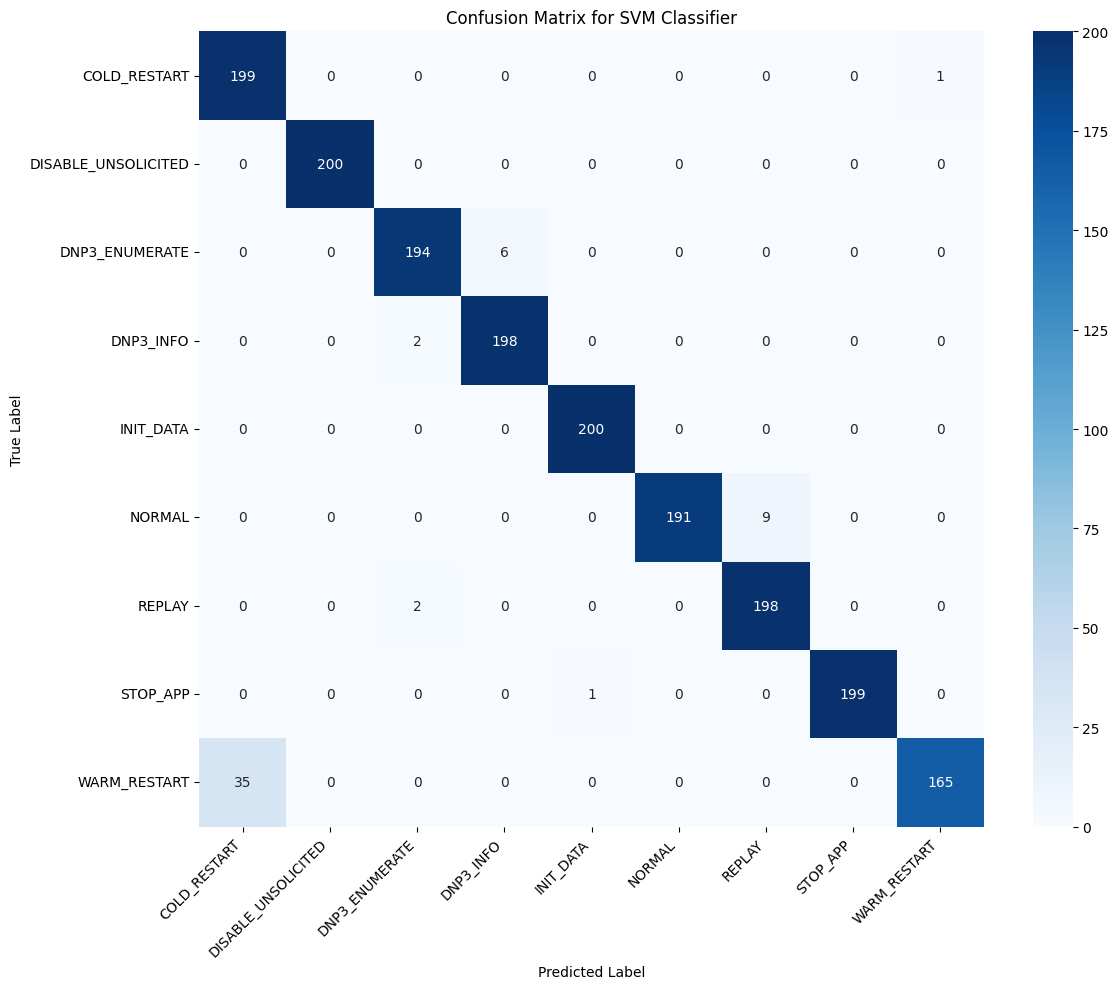


Predictions saved to svm_predictions_engineered_features.csv

--- Script Finished ---


In [4]:
# --- Reporting ---
accuracy = accuracy_score(y_test, y_pred) # Use encoded labels for metric calculation
print(f"\nTest Set Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
# Get target names from the fitted label encoder
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM Classifier")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Save Predictions ---
svm_predictions = pd.DataFrame({'Predicted_SVM': y_pred_labels, 'Actual': y_test_labels})
output_filename = "svm_predictions_engineered_features.csv"
svm_predictions.to_csv(output_filename, index=False)
print(f"\nPredictions saved to {output_filename}")

print("\n--- Script Finished ---")

In [4]:
# Base Imports
import pandas as pd
import numpy as np
import os
import warnings
import time

# Scikit-learn Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

# TensorFlow / Keras Imports (for ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Statsmodels Import (for McNemar)
from statsmodels.stats.contingency_tables import mcnemar

# Plotting Imports
import seaborn as sns
import matplotlib.pyplot as plt

# --- Warning Handling ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Configuration ---
# File Paths
training_data_path = "../DNP3_Intrusion_Detection_Dataset_Final/Training_Testing_Balanced_CSV_Files/Custom_DNP3_Parser/Custom_DNP3_Parser_Training_Balanced.csv"
testing_data_path = "../DNP3_Intrusion_Detection_Dataset_Final/Training_Testing_Balanced_CSV_Files/Custom_DNP3_Parser/Custom_DNP3_Parser_Testing_Balanced.csv"
prediction_output_dir = "." # Directory to save prediction CSVs

# Preprocessing & Model Parameters
# PCA_N_COMPONENTS will be defined *after* PCA analysis plot
SVM_C_VALUES = [50] # Using only the best found previously
SVM_GAMMA_VALUES = [0.1] # Using only the best found previously
SVM_KERNEL_VALUES = ['rbf'] # Using only the best found previously
CV_FOLDS = 5
TEST_SET_SIZE = 0.5 # Proportion of original test data for final test set
RANDOM_STATE = 42



ModuleNotFoundError: No module named 'tensorflow.python'

# Load Data 

In [ ]:
print("Loading data...")
try:
    train_data = pd.read_csv(training_data_path)
    original_test_data = pd.read_csv(testing_data_path)
    print("Data loaded successfully.")
    train_data.columns = train_data.columns.str.strip()
    original_test_data.columns = original_test_data.columns.str.strip()
except FileNotFoundError:
    print(f"Error: Input file not found. Ensure '{training_data_path}' and '{testing_data_path}' exist.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Feature Engineering and Preprocessing Function 

In [ ]:
def preprocess_data(df, is_training=True, fit_objects=None):
    print(f"\nPreprocessing {'Training' if is_training else 'Validation/Test'} Data...")
    df = df.copy()
    df.columns = df.columns.str.strip()

    if is_training:
        fit_objects = {
            'label_encoder': LabelEncoder(),
            'imputer': SimpleImputer(strategy='median'),
            'scaler': StandardScaler(),
            'ip_freq_maps': {},
            'date_medians': {},
            'dropped_all_nan_cols': [],
            'final_scaled_columns': []
        }
    elif fit_objects is None:
        raise ValueError("fit_objects dictionary must be provided for validation/test data preprocessing.")

    if 'date' in df.columns:
        print("Engineering Date Features...")
        try:
            df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
            df['hour'] = df['date'].dt.hour
            df['minute'] = df['date'].dt.minute
            df['second'] = df['date'].dt.second
            df['dayofweek'] = df['date'].dt.dayofweek
            time_cols = ['hour', 'minute', 'second', 'dayofweek']
            for col in time_cols:
                if col in df.columns:
                    median_val = df[col].median() if is_training else fit_objects['date_medians'].get(col, df[col].median())
                    if is_training:
                        fit_objects['date_medians'][col] = median_val
                    df[col].fillna(median_val, inplace=True)
            df.drop('date', axis=1, inplace=True)
        except Exception as e:
            print(f"Error processing 'date' column: {e}. Skipping date features.")
            if 'date' in df.columns:
                df.drop('date', axis=1, inplace=True, errors='ignore')
    else:
        print("Warning: 'date' column not found.")

    for col in ['source IP', 'destination IP']:
        if col in df.columns:
            print(f"Encoding '{col}' Frequency...")
            map_name = f"{col}_freq_map"
            freq_col_name = f"{col}_freq"
            if is_training:
                freq_map = df[col].value_counts().to_dict()
                fit_objects['ip_freq_maps'][map_name] = freq_map
                df[freq_col_name] = df[col].map(freq_map)
                df[freq_col_name].fillna(0, inplace=True)
            else:
                freq_map = fit_objects['ip_freq_maps'].get(map_name, {})
                df[freq_col_name] = df[col].map(freq_map)
                df[freq_col_name].fillna(0, inplace=True)
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Warning: '{col}' column not found.")

    if 'flow ID' in df.columns:
        print("Converting 'flow ID'...")
        df['flow ID_numeric'] = pd.to_numeric(df['flow ID'], errors='coerce')
        df.drop('flow ID', axis=1, inplace=True)
    else:
         print("Warning: 'flow ID' column not found.")

    if 'firstPacketDIR' in df.columns:
        print("Mapping 'firstPacketDIR'...")
        dir_map = {'MASTER': 0, 'OUTSTATION': 1}
        df['firstPacketDIR'] = df['firstPacketDIR'].map(dir_map)
        df['firstPacketDIR'].fillna(-1, inplace=True)
    else:
        print("Warning: 'firstPacketDIR' column not found.")

    columns_to_drop_generic = ['Unnamed: 0.1', 'Unnamed: 0']
    cols_present = [col for col in columns_to_drop_generic if col in df.columns]
    if cols_present:
        print(f"Dropping generic columns: {cols_present}")
        df.drop(columns=cols_present, inplace=True, errors='ignore')

    y = None
    y_encoded = None
    if 'Label' in df.columns:
        print("Processing Target Variable 'Label'...")
        y = df['Label'].fillna('Unknown')
        X = df.drop('Label', axis=1)
        print(f"Unique values in Label column: {y.unique()}")

        le = fit_objects['label_encoder']
        if is_training:
            y_encoded = le.fit_transform(y)
        else:
            seen_labels = set(le.classes_)
            current_labels = set(y.unique())
            unseen_labels = current_labels - seen_labels
            if unseen_labels:
                print(f"Warning: Found unseen labels in validation/test data: {unseen_labels}.")
                if 'Unknown' in seen_labels:
                    print("Mapping unseen labels to 'Unknown'.")
                    y = y.apply(lambda x: x if x in seen_labels else 'Unknown')
                    y_encoded = le.transform(y)
                else:
                     print("Attempting transform, may error later if unseen labels cannot be handled and 'Unknown' was not trained.")
                     try:
                         y_encoded = le.transform(y)
                     except ValueError:
                         print("ValueError during transform due to unseen labels and no 'Unknown' fallback.")
                         y_encoded = None
                         X = X.iloc[0:0] # Make X empty to signal failure
                         y = y.iloc[0:0]   # Make y empty
            else:
                 y_encoded = le.transform(y)

    else:
        print("Warning: 'Label' column not found. Assuming data is features only (X).")
        X = df

    # Only proceed with feature processing if X is not empty (due to label errors)
    if not X.empty:
        print("Converting remaining feature columns to numeric...")
        feature_cols = X.columns.tolist()
        for col in feature_cols:
            if X[col].dtype == 'object':
                X[col] = pd.to_numeric(X[col], errors='coerce')

        if is_training:
            all_nan_cols = X.columns[X.isna().all()].tolist()
            if all_nan_cols:
                print(f"Warning: The following columns are entirely NaN after coercion: {all_nan_cols}")
                print("Dropping these columns before imputation.")
                X = X.drop(columns=all_nan_cols)
                fit_objects['dropped_all_nan_cols'] = all_nan_cols
                print(f"Shape of X after dropping all-NaN columns: {X.shape}")
            feature_cols = X.columns.tolist() # Update feature_cols after dropping
        else:
            cols_to_drop_test = fit_objects.get('dropped_all_nan_cols', [])
            if cols_to_drop_test:
                cols_to_drop_test_existing = [col for col in cols_to_drop_test if col in X.columns]
                if cols_to_drop_test_existing:
                    print(f"Dropping columns found to be all-NaN during training: {cols_to_drop_test_existing}")
                    X = X.drop(columns=cols_to_drop_test_existing)
                    print(f"Shape of X after dropping corresponding all-NaN columns: {X.shape}")
                feature_cols = X.columns.tolist() # Update feature_cols

        print(f"Features count before imputation: {X.shape[1]}")
        print("Imputing missing values (median strategy)...")
        imputer = fit_objects['imputer']
        if is_training:
            X_imputed = imputer.fit_transform(X)
        else:
            if not hasattr(imputer, 'statistics_'):
                 raise RuntimeError("Imputer was not fitted during training.")
            X_imputed = imputer.transform(X)

        X_imputed_df = pd.DataFrame(X_imputed, columns=feature_cols, index=X.index)

        print("Scaling features...")
        scaler = fit_objects['scaler']
        if is_training:
            X_scaled = scaler.fit_transform(X_imputed_df)
            fit_objects['final_scaled_columns'] = X_imputed_df.columns.tolist()
        else:
            if not hasattr(scaler, 'scale_'):
                 raise RuntimeError("Scaler was not fitted during training.")
            X_scaled = scaler.transform(X_imputed_df)

        X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X_imputed_df.index)

        if not is_training:
            final_scaled_columns = fit_objects.get('final_scaled_columns')
            if final_scaled_columns:
                X_scaled_df = X_scaled_df.reindex(columns=final_scaled_columns, fill_value=0)
            else:
                print("Warning: 'final_scaled_columns' not found in fit_objects. Column alignment might fail.")
    else:
         # If X became empty due to label issues, return empty DataFrame
         X_scaled_df = X.copy()

    print(f"Preprocessing complete. Final scaled feature shape: {X_scaled_df.shape}")

    if is_training:
        return X_scaled_df, y_encoded, fit_objects
    else:
        return X_scaled_df, y_encoded, None

# Plotting Function 

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    if y_true is None or y_pred is None or len(y_true) == 0 or len(y_pred) == 0:
        print(f"Skipping confusion matrix for '{title}' due to missing or empty data.")
        return
    try:
        # Ensure labels used for confusion matrix exist in both y_true and y_pred if possible
        unique_labels = np.unique(np.concatenate((y_true, y_pred)))
        plot_labels = [l for l in labels if l in unique_labels]
        if not plot_labels: # Fallback if no common labels somehow (shouldn't happen if preprocessing worked)
            plot_labels=labels

        cm = confusion_matrix(y_true, y_pred, labels=plot_labels) # Use filtered labels
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=plot_labels, yticklabels=plot_labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix for '{title}': {e}")

# Split Original Test Data into Validation and Final Test 

In [ ]:
print("\n--- Splitting Original Test Data ---")
if 'Label' in original_test_data.columns:
    try:
        val_data, test_data = train_test_split(
            original_test_data,
            test_size=TEST_SET_SIZE,
            random_state=RANDOM_STATE,
            stratify=original_test_data['Label']
        )
        print(f"Original Test Data split into Validation ({len(val_data)} samples) and Final Test ({len(test_data)} samples).")
    except ValueError as e:
         print(f"Warning: Could not stratify split: {e}. Performing non-stratified split.")
         val_data, test_data = train_test_split(
            original_test_data,
            test_size=TEST_SET_SIZE,
            random_state=RANDOM_STATE
         )
         print(f"Original Test Data split into Validation ({len(val_data)} samples) and Final Test ({len(test_data)} samples) without stratification.")
else:
    print("Warning: 'Label' column not found in original test data. Cannot stratify split.")
    val_data, test_data = train_test_split(
        original_test_data,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_STATE
    )
    print(f"Original Test Data split into Validation ({len(val_data)} samples) and Final Test ({len(test_data)} samples).")


# --- Preprocess All Datasets ---
print("\n--- Preprocessing All Datasets ---")
X_train_scaled, y_train, fit_objects = preprocess_data(train_data, is_training=True)
X_val_scaled, y_val, _             = preprocess_data(val_data, is_training=False, fit_objects=fit_objects)
X_test_scaled, y_test, _            = preprocess_data(test_data, is_training=False, fit_objects=fit_objects)

# PCA Analysis & Visualization 

In [ ]:
print("\n--- PCA Analysis & Visualization ---")
# Fit PCA on scaled training data *before* dimensionality reduction to analyze variance
pca_analyzer = PCA(random_state=RANDOM_STATE)
# Only fit PCA analyzer if training data exists and is not empty
if X_train_scaled is not None and not X_train_scaled.empty:
    try:
        pca_analyzer.fit(X_train_scaled)
        cumulative_variance = np.cumsum(pca_analyzer.explained_variance_ratio_)
        total_possible_components = len(cumulative_variance)

        # --- Plotting PCA Variance ---
        plt.figure(figsize=(12, 7))
        plt.plot(range(1, total_possible_components + 1), cumulative_variance,
                 marker='.', linestyle='--', label='Cumulative Variance Curve',
                 color='grey', alpha=0.7)

        # Add 95% and 99% threshold lines if desired
        try:
            components_95 = np.argmax(cumulative_variance >= 0.95) + 1
            plt.axvline(components_95, linestyle=':', color='blue', alpha=0.5, label=f'~{components_95} comps for 95%')
            plt.axhline(0.95, linestyle=':', color='blue', label='95% Variance Threshold')
        except (ValueError, IndexError): pass # Threshold not reached or index error

        try:
            components_99 = np.argmax(cumulative_variance >= 0.99) + 1
            plt.axvline(components_99, linestyle=':', color='green', alpha=0.5, label=f'~{components_99} comps for 99%')
            plt.axhline(0.99, linestyle=':', color='green', label='99% Variance Threshold')
        except (ValueError, IndexError): pass # Threshold not reached or index error

        plt.title('Cumulative Explained Variance by PCA Components', fontsize=16)
        plt.xlabel('Number of Principal Components', fontsize=12)
        plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
        plt.ylim(0, 1.05)
        plt.xlim(0, min(total_possible_components + 1, 100)) # Limit x-axis for better view if many components
        plt.xticks(np.arange(0, min(total_possible_components + 1, 101), step=max(1, min(total_possible_components, 100) // 10)))
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='best', fontsize=10)
        plt.tight_layout()
        plt.show()

        # --- DEFINE PCA COMPONENTS BASED ON PLOT ---
        # *** INSPECT THE PLOT ABOVE AND CHOOSE THE NUMBER OF COMPONENTS ***
        PCA_N_COMPONENTS = 15 # Example: Set based on the plot analysis
        print(f"\nSelected number of PCA components: {PCA_N_COMPONENTS}")
        # --- End of User Definition ---

    except Exception as e:
        print(f"Error during PCA analysis/plotting: {e}")
        print("Setting PCA_N_COMPONENTS to a default value (e.g., 15) or None.")
        PCA_N_COMPONENTS = 15 # Or None if you want to skip PCA
else:
    print("Skipping PCA analysis as scaled training data is not available.")
    PCA_N_COMPONENTS = None # Cannot perform PCA


# Applying Final PCA Transformation 

In [ ]:
print("\n--- Applying Final PCA Transformation ---")
# Only apply PCA if components are defined and data exists
if PCA_N_COMPONENTS is not None and X_train_scaled is not None and not X_train_scaled.empty:
    pca_final = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)

    # Fit PCA on training data and transform all sets
    X_train = pca_final.fit_transform(X_train_scaled)
    X_val = pca_final.transform(X_val_scaled) if X_val_scaled is not None and not X_val_scaled.empty else None
    X_test = pca_final.transform(X_test_scaled) if X_test_scaled is not None and not X_test_scaled.empty else None

    # Store PCA object
    fit_objects['pca'] = pca_final

    # Create DataFrames for PCA results
    pca_cols = [f'PC_{i+1}' for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=pca_cols, index=X_train_scaled.index)
    if X_val is not None:
        X_val = pd.DataFrame(X_val, columns=pca_cols, index=X_val_scaled.index)
    if X_test is not None:
        X_test = pd.DataFrame(X_test, columns=pca_cols, index=X_test_scaled.index)

    # Store final columns after PCA
    fit_objects['final_columns'] = pca_cols

    explained_variance_selected = np.sum(pca_final.explained_variance_ratio_)
    print(f"Shape after PCA: Train={X_train.shape}",
          f"Val={X_val.shape if X_val is not None else 'N/A'}",
          f"Test={X_test.shape if X_test is not None else 'N/A'}")
    print(f"Variance explained by {PCA_N_COMPONENTS} components: {explained_variance_selected:.4f}")
else:
    print("Skipping final PCA transformation.")
    # Use scaled data directly if PCA was skipped
    X_train = X_train_scaled
    X_val = X_val_scaled
    X_test = X_test_scaled
    if 'final_scaled_columns' in fit_objects:
         fit_objects['final_columns'] = fit_objects['final_scaled_columns']

# Data Validation 

In [ ]:
print("\n--- Validating Preprocessed Data (Post-PCA/Scaling) ---")
valid_data = True
label_encoder = fit_objects.get('label_encoder', None) # Get label encoder for checking

if label_encoder is None and (y_train is not None or y_val is not None or y_test is not None):
     print("Error: Label encoder not found in fit_objects, but label data exists.")
     valid_data = False

for name, data, labels in [('X_train', X_train, y_train), ('X_val', X_val, y_val), ('X_test', X_test, y_test)]:
    if data is None:
        print(f"Error: Feature data ({name}) is None.")
        valid_data = False
        continue # Skip further checks for this dataset
    elif data.empty:
         # Allow empty if labels are also empty (e.g., due to earlier label error)
        if labels is not None and len(labels) > 0:
            print(f"Error: Feature data ({name}) is empty but labels exist.")
            valid_data = False
        else:
            print(f"Info: Feature data ({name}) and corresponding labels are empty.")
        continue
    elif np.any(np.isnan(data.values)) or np.any(np.isinf(data.values)):
         print(f"Error: NaNs or Infs found in {name} after preprocessing.")
         valid_data = False

    if labels is None:
        # Only an error if X is not empty
        if not data.empty:
             print(f"Error: Target data ({name.replace('X', 'y')}) is None, but feature data exists.")
             valid_data = False
    elif len(labels) != len(data):
         print(f"Error: Mismatch between number of samples in {name} ({len(data)}) and {name.replace('X', 'y')} ({len(labels)}).")
         valid_data = False
    elif np.any(np.isnan(labels)) or np.any(np.isinf(labels)):
         print(f"Error: NaNs or Infs found in {name.replace('X', 'y')} after preprocessing.")
         valid_data = False
    # Check if all labels in val/test are known to the encoder (only if encoder exists)
    elif name != 'X_train' and label_encoder is not None:
         try:
             unique_numeric_labels = np.unique(labels[~np.isnan(labels)]) # Ignore potential NaNs introduced earlier
             known_numeric_labels = np.arange(len(label_encoder.classes_))
             unknown_in_set = set(unique_numeric_labels) - set(known_numeric_labels)
             if unknown_in_set:
                 print(f"Error: Unknown numeric labels {unknown_in_set} found in {name.replace('X','y')} which are not in the label encoder.")
                 valid_data = False
         except Exception as e:
              print(f"Error checking labels in {name.replace('X','y')}: {e}")
              valid_data = False


if not valid_data or X_train is None or X_train.empty or y_train is None or len(y_train) == 0:
    print("Cannot proceed with model training due to data issues or empty training set.")
    exit()
else:
    print("Preprocessed data appears valid for training and evaluation.")


# --- Model Training and Evaluation ---
results = {} # To store metrics for the dashboard
predictions = {} # To store test set predictions for McNemar

# Get target names for plotting/reporting
try:
    target_names = label_encoder.classes_.astype(str)
except Exception as e:
    print(f"Warning: Could not get target names from LabelEncoder: {e}. Using numeric labels.")
    target_names = np.unique(y_train).astype(str)

# 1. ANN Model 

In [ ]:
# ANN Parameters
ANN_EPOCHS = 50
ANN_BATCH_SIZE = 32
ANN_VERBOSE = 0
print("\n--- Setting up ANN Model ---")
start_time = time.time()
ann_model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],)), # Input shape based on final features
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(len(target_names), activation="softmax"),
    ]
)
ann_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print(ann_model.summary())

print(f"\nTraining ANN (Epochs={ANN_EPOCHS}, Batch Size={ANN_BATCH_SIZE})...")
# Only train if validation data exists
if X_val is not None and not X_val.empty and y_val is not None and len(y_val) > 0:
    history = ann_model.fit(X_train, y_train, epochs=ANN_EPOCHS, batch_size=ANN_BATCH_SIZE,
                            validation_data=(X_val, y_val), verbose=ANN_VERBOSE)
else:
    print("Skipping validation during ANN training as validation data is missing.")
    history = ann_model.fit(X_train, y_train, epochs=ANN_EPOCHS, batch_size=ANN_BATCH_SIZE, verbose=ANN_VERBOSE)


print("\n--- Evaluating ANN Model on Test Set ---")
if X_test is not None and not X_test.empty and y_test is not None and len(y_test) > 0:
    loss, accuracy_test_ann = ann_model.evaluate(X_test, y_test, verbose=ANN_VERBOSE)
    y_pred_prob_ann = ann_model.predict(X_test)
    y_pred_test_ann = np.argmax(y_pred_prob_ann, axis=1)

    results['ANN'] = {'accuracy': accuracy_test_ann}
    # ANN predictions usually not directly compared with McNemar, skip storage for now
    # predictions['ANN'] = y_pred_test_ann

    try:
        y_pred_test_labels_ann = label_encoder.inverse_transform(y_pred_test_ann)
        y_test_labels = label_encoder.inverse_transform(y_test)
    except Exception as e:
        print(f"Error inverse transforming ANN test labels: {e}. Using encoded labels.")
        y_pred_test_labels_ann = y_pred_test_ann
        y_test_labels = y_test # Use encoded true labels

    print(f"Test Set Accuracy (ANN): {accuracy_test_ann:.4f}")
    print("\nTest Set Classification Report (ANN):")
    report_ann = classification_report(y_test_labels, y_pred_test_labels_ann, target_names=target_names, output_dict=True, zero_division=0)
    print(classification_report(y_test_labels, y_pred_test_labels_ann, target_names=target_names, zero_division=0))
    results['ANN']['report'] = report_ann
    plot_confusion_matrix(y_test_labels, y_pred_test_labels_ann, target_names, "Confusion Matrix for ANN Classifier (Test Set)")
else:
    print("Skipping ANN evaluation as test data is missing.")
    y_test_labels = None # Ensure y_test_labels is None if test evaluation skipped

print(f"ANN training and evaluation took {time.time() - start_time:.2f} seconds.")

# 2. Random Forest

In [ ]:
print("\n--- Setting up Random Forest Model ---")
start_time = time.time()
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
print(f"\nTraining Random Forest...")
rf_model.fit(X_train, y_train)

print("\n--- Evaluating Random Forest Model on Test Set ---")
if X_test is not None and not X_test.empty and y_test is not None and len(y_test) > 0:
    y_pred_test_rf = rf_model.predict(X_test)
    accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
    results['RF'] = {'accuracy': accuracy_test_rf}
    predictions['RF'] = y_pred_test_rf

    try:
        y_pred_test_labels_rf = label_encoder.inverse_transform(y_pred_test_rf)
    except Exception as e:
        print(f"Error inverse transforming RF test labels: {e}. Using encoded labels.")
        y_pred_test_labels_rf = y_pred_test_rf

    print(f"Test Set Accuracy (RF): {accuracy_test_rf:.4f}")
    print("\nTest Set Classification Report (RF):")
    report_rf = classification_report(y_test_labels, y_pred_test_labels_rf, target_names=target_names, output_dict=True, zero_division=0)
    print(classification_report(y_test_labels, y_pred_test_labels_rf, target_names=target_names, zero_division=0))
    results['RF']['report'] = report_rf
    plot_confusion_matrix(y_test_labels, y_pred_test_labels_rf, target_names, "Confusion Matrix for Random Forest Classifier (Test Set)")
else:
     print("Skipping RF evaluation as test data is missing.")
print(f"RF training and evaluation took {time.time() - start_time:.2f} seconds.")

# 3. Gradient Boosting


In [ ]:
print("\n--- Setting up Gradient Boosting Model ---")
start_time = time.time()
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100)
print(f"\nTraining Gradient Boosting...")
gb_model.fit(X_train, y_train)

print("\n--- Evaluating Gradient Boosting Model on Test Set ---")
if X_test is not None and not X_test.empty and y_test is not None and len(y_test) > 0:
    y_pred_test_gb = gb_model.predict(X_test)
    accuracy_test_gb = accuracy_score(y_test, y_pred_test_gb)
    results['GB'] = {'accuracy': accuracy_test_gb}
    predictions['GB'] = y_pred_test_gb

    try:
        y_pred_test_labels_gb = label_encoder.inverse_transform(y_pred_test_gb)
    except Exception as e:
        print(f"Error inverse transforming GB test labels: {e}. Using encoded labels.")
        y_pred_test_labels_gb = y_pred_test_gb

    print(f"Test Set Accuracy (GB): {accuracy_test_gb:.4f}")
    print("\nTest Set Classification Report (GB):")
    report_gb = classification_report(y_test_labels, y_pred_test_labels_gb, target_names=target_names, output_dict=True, zero_division=0)
    print(classification_report(y_test_labels, y_pred_test_labels_gb, target_names=target_names, zero_division=0))
    results['GB']['report'] = report_gb
    plot_confusion_matrix(y_test_labels, y_pred_test_labels_gb, target_names, "Confusion Matrix for Gradient Boosting Classifier (Test Set)")
else:
     print("Skipping GB evaluation as test data is missing.")
print(f"GB training and evaluation took {time.time() - start_time:.2f} seconds.")

# 4. XGBoost


In [ ]:
print("\n--- Setting up XGBoost Model ---")
start_time = time.time()
xgb_model = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
print(f"\nTraining XGBoost...")
xgb_model.fit(X_train, y_train)

print("\n--- Evaluating XGBoost Model on Test Set ---")
if X_test is not None and not X_test.empty and y_test is not None and len(y_test) > 0:
    y_pred_test_xgb = xgb_model.predict(X_test)
    accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
    results['XGB'] = {'accuracy': accuracy_test_xgb}
    predictions['XGB'] = y_pred_test_xgb

    try:
        y_pred_test_labels_xgb = label_encoder.inverse_transform(y_pred_test_xgb)
    except Exception as e:
        print(f"Error inverse transforming XGB test labels: {e}. Using encoded labels.")
        y_pred_test_labels_xgb = y_pred_test_xgb

    print(f"Test Set Accuracy (XGB): {accuracy_test_xgb:.4f}")
    print("\nTest Set Classification Report (XGB):")
    report_xgb = classification_report(y_test_labels, y_pred_test_labels_xgb, target_names=target_names, output_dict=True, zero_division=0)
    print(classification_report(y_test_labels, y_pred_test_labels_xgb, target_names=target_names, zero_division=0))
    results['XGB']['report'] = report_xgb
    plot_confusion_matrix(y_test_labels, y_pred_test_labels_xgb, target_names, "Confusion Matrix for XGBoost Classifier (Test Set)")
else:
    print("Skipping XGB evaluation as test data is missing.")
print(f"XGB training and evaluation took {time.time() - start_time:.2f} seconds.")


# --- 5. SVM with GridSearchCV ---
print("\n--- Setting up SVM Model and GridSearchCV ---")
start_time = time.time()
svm_model = SVC(random_state=RANDOM_STATE, probability=True)
param_grid_svm = {'C': SVM_C_VALUES, 'gamma': SVM_GAMMA_VALUES, 'kernel': SVM_KERNEL_VALUES}

print(f"Performing GridSearchCV for SVM (CV Folds = {CV_FOLDS})...")
print(f"Parameter Grid: {param_grid_svm}")

# Use X_train and y_train which are post-PCA


In [ ]:
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, refit=True, verbose=1, cv=CV_FOLDS, n_jobs=-1)

best_svm = None
try:
    grid_search_svm.fit(X_train, y_train)
    best_svm = grid_search_svm.best_estimator_
    print("\nGridSearchCV finished.")
    print(f"Best Parameters found: {grid_search_svm.best_params_}")
    print(f"Best Model: {best_svm}")
except ValueError as e:
    print(f"\nError during GridSearchCV fit: {e}")
    best_svm = None # Ensure best_svm is None if CV fails

# --- Evaluate Best SVM on Validation Set ---
print("\n--- Evaluating Best SVM Model on Validation Set ---")
if best_svm is not None and X_val is not None and not X_val.empty and y_val is not None and len(y_val) > 0:
    y_pred_val_svm = best_svm.predict(X_val)
    accuracy_val_svm = accuracy_score(y_val, y_pred_val_svm)
    results['SVM'] = {} # Initialize SVM results
    results['SVM']['val_accuracy'] = accuracy_val_svm

    try:
        y_pred_val_labels_svm = label_encoder.inverse_transform(y_pred_val_svm)
        y_val_labels = label_encoder.inverse_transform(y_val)
        target_names_val = target_names # Use the same names derived earlier
    except Exception as e:
        print(f"Error inverse transforming SVM validation labels: {e}. Using encoded labels.")
        y_pred_val_labels_svm = y_pred_val_svm
        y_val_labels = y_val
        target_names_val = np.unique(y_val).astype(str)

    print(f"Validation Set Accuracy (SVM): {accuracy_val_svm:.4f}")
    print("\nValidation Set Classification Report (SVM):")
    report_val_svm = classification_report(y_val_labels, y_pred_val_labels_svm, target_names=target_names_val, output_dict=True, zero_division=0)
    print(classification_report(y_val_labels, y_pred_val_labels_svm, target_names=target_names_val, zero_division=0))
    results['SVM']['val_report'] = report_val_svm
    plot_confusion_matrix(y_val_labels, y_pred_val_labels_svm, target_names_val, "Confusion Matrix for SVM Classifier (Validation Set)")
else:
    print("Skipping SVM validation evaluation as model or validation data is missing.")
    if 'SVM' not in results: results['SVM'] = {}
    results['SVM']['val_accuracy'] = None
    results['SVM']['val_report'] = None

# --- Evaluate Best SVM on Test Set ---

In [ ]:
print("\n--- Evaluating Best SVM Model on Test Set ---")
if best_svm is not None and X_test is not None and not X_test.empty and y_test is not None and len(y_test) > 0:
    y_pred_test_svm = best_svm.predict(X_test)
    accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
    if 'SVM' not in results: results['SVM'] = {} # Initialize if validation failed
    results['SVM']['accuracy'] = accuracy_test_svm
    predictions['SVM'] = y_pred_test_svm

    try:
        y_pred_test_labels_svm = label_encoder.inverse_transform(y_pred_test_svm)
    except Exception as e:
        print(f"Error inverse transforming SVM test labels: {e}. Using encoded labels.")
        y_pred_test_labels_svm = y_pred_test_svm

    print(f"Test Set Accuracy (SVM): {accuracy_test_svm:.4f}")
    print("\nTest Set Classification Report (SVM):")
    report_test_svm = classification_report(y_test_labels, y_pred_test_labels_svm, target_names=target_names, output_dict=True, zero_division=0)
    print(classification_report(y_test_labels, y_pred_test_labels_svm, target_names=target_names, zero_division=0))
    results['SVM']['report'] = report_test_svm
    plot_confusion_matrix(y_test_labels, y_pred_test_labels_svm, target_names, "Confusion Matrix for SVM Classifier (Test Set)")
else:
    print("Skipping SVM test evaluation as model or test data is missing.")
    if 'SVM' not in results: results['SVM'] = {}
    results['SVM']['accuracy'] = None
    results['SVM']['report'] = None

print(f"SVM training (with CV) and evaluation took {time.time() - start_time:.2f} seconds.")


# --- Save Test Predictions ---
# Ensure the directory exists
os.makedirs(prediction_output_dir, exist_ok=True)

# Save True Labels if they exist


In [ ]:
if y_test_labels is not None and len(y_test_labels) > 0 and X_test is not None and not X_test.empty:
    print("\n--- Saving True Test Set Labels ---")
    true_label_output_file = os.path.join(prediction_output_dir, "true_labels.csv")
    true_labels_df = pd.DataFrame({'Actual': y_test_labels}, index=X_test.index)
    try:
        true_labels_df.to_csv(true_label_output_file, index_label='OriginalIndex')
        print(f"True test labels saved to {true_label_output_file}")
    except Exception as e:
        print(f"Error saving true labels: {e}")

# Save predictions for each ML model if they exist
print("\n--- Saving Test Set Predictions for ML Models ---")
model_preds_to_save = {
    "SVM": predictions.get('SVM', None),
    "RF": predictions.get('RF', None),
    "GB": predictions.get('GB', None),
    "XGB": predictions.get('XGB', None),
}

if y_test_labels is not None and X_test is not None and not X_test.empty: # Only save if true labels and test features exist
    for model_name, pred_encoded in model_preds_to_save.items():
        if pred_encoded is None:
            print(f"Skipping saving predictions for {model_name} as they are missing.")
            continue

        output_filename = os.path.join(prediction_output_dir, f"{model_name.lower()}_predictions.csv")
        output_filename_enc = os.path.join(prediction_output_dir, f"{model_name.lower()}_predictions_encoded.csv")

        try:
            # Try saving readable labels first
            pred_labels = label_encoder.inverse_transform(pred_encoded)
            predictions_df = pd.DataFrame({f'Predicted_{model_name}': pred_labels, 'Actual': y_test_labels}, index=X_test.index)
            predictions_df.to_csv(output_filename, index_label='OriginalIndex')
            print(f"{model_name} test predictions saved to {output_filename}")
        except Exception as e:
            print(f"Error saving readable {model_name} predictions: {e}")
            print("Attempting to save with encoded labels as fallback.")
            try:
                predictions_encoded_df = pd.DataFrame({f'Predicted_{model_name}_Encoded': pred_encoded, 'Actual_Encoded': y_test}, index=X_test.index)
                predictions_encoded_df.to_csv(output_filename_enc, index_label='OriginalIndex')
                print(f"Test predictions (encoded) for {model_name} saved to {output_filename_enc}")
            except Exception as e_enc:
                print(f"Could not save encoded {model_name} predictions either: {e_enc}")
else:
    print("Skipping saving of predictions as true labels or test features are missing.")

#  Statistical Testing (McNemar's Test - Comparing SVM to others) 


In [ ]:
print("\n--- Statistical Testing (McNemar's Test: SVM vs Others) ---")

def perform_mcnemar_test(base_model_name, compare_model_name, base_preds, compare_preds, true_labels_numeric):
    """Performs McNemar test comparing two models' predictions."""
    print(f"\nComparing {base_model_name} vs. {compare_model_name}...")
    if base_preds is None or compare_preds is None or true_labels_numeric is None:
        print("Error: Missing prediction or true label data. Cannot perform test.")
        return None, None, None
    if len(base_preds) != len(compare_preds) or len(base_preds) != len(true_labels_numeric):
        print("Error: Prediction arrays or true labels have different lengths. Cannot perform test.")
        return None, None, None

    base_correct = (base_preds == true_labels_numeric)
    compare_correct = (compare_preds == true_labels_numeric)

    a = np.sum((base_correct == 1) & (compare_correct == 1))
    b = np.sum((base_correct == 1) & (compare_correct == 0)) # SVM correct, Other incorrect
    c = np.sum((base_correct == 0) & (compare_correct == 1)) # SVM incorrect, Other correct
    d = np.sum((base_correct == 0) & (compare_correct == 0))

    table = [[a, b], [c, d]]

    if b + c < 1:
         print("Warning: Sum of discordant cells (b+c) is zero. Cannot perform McNemar's test.")
         return None, None, table
    elif b + c < 25:
         print(f"Warning: Sum of discordant cells ({b+c}) is low (<25). Using exact binomial test.")
         # statsmodels mcnemar with exact=True uses binomial test
         try:
             result = mcnemar(table, exact=True) # exact=True for binomial test
             p_value = result.pvalue
             print(f"  Contingency Table:\n    [[{a}, {b}],\n     [{c}, {d}]]")
             print(f"  Exact Binomial p-value: {p_value:.4e}")
             if p_value < 0.05:
                 print("  Result: Significant difference detected (p < 0.05).")
             else:
                 print("  Result: No significant difference detected (p >= 0.05).")
             return None, p_value, table # Return None for chi2 when exact test is used
         except Exception as e:
             print(f"Error during exact McNemar test: {e}")
             return None, None, table
    else:
        # Use Chi2 with continuity correction if b+c >= 25
        try:
            result = mcnemar(table, exact=False, correction=True)
            chi2_stat = result.statistic
            p_value = result.pvalue
            print(f"  Contingency Table:\n    [[{a}, {b}],\n     [{c}, {d}]]")
            print(f"  Chi-squared (corrected): {chi2_stat:.4f}, p-value: {p_value:.4e}")
            if p_value < 0.05:
                print("  Result: Significant difference detected (p < 0.05).")
            else:
                print("  Result: No significant difference detected (p >= 0.05).")
            return chi2_stat, p_value, table
        except Exception as e:
            print(f"Error during McNemar test (Chi2): {e}")
            return None, None, table

# Perform tests comparing SVM to other ML models if predictions exist
mcnemar_results = {}
if 'SVM' in predictions and y_test is not None:
    for model_name in ['RF', 'GB', 'XGB']:
        if model_name in predictions:
            chi2, p, table = perform_mcnemar_test('SVM', model_name, predictions['SVM'], predictions[model_name], y_test)
            mcnemar_results[model_name] = {'chi2': chi2, 'p_value': p, 'table': table}
        else:
            print(f"Skipping McNemar test for {model_name} as its predictions were not found.")
elif y_test is None:
     print("Skipping McNemar tests as true test labels (y_test) are missing.")
else:
     print("Skipping McNemar tests as SVM predictions are missing.")

# Generate Results Dashboard

In [ ]:

print("\n--- Generating Results Dashboard ---")

ml_models = ['SVM', 'RF', 'GB', 'XGB']
dashboard_accuracies = []
dashboard_labels = []
for m in ml_models:
    if m in results and 'accuracy' in results[m] and results[m]['accuracy'] is not None:
         dashboard_accuracies.append(results[m]['accuracy'])
         dashboard_labels.append(m)
    else:
         print(f"Warning: Accuracy results for {m} not found, skipping from dashboard accuracy plot.")

svm_val_f1_scores = {}
svm_test_f1_scores = {}
if 'SVM' in results and results.get('SVM', {}).get('val_report') and results.get('SVM', {}).get('report') and target_names is not None:
    class_names_val = [name for name in target_names if name in results['SVM']['val_report']]
    class_names_test = [name for name in target_names if name in results['SVM']['report']]
    # Use test class names as the reference order, assuming they are the superset or most relevant
    class_names_dashboard = class_names_test

    for cls in class_names_dashboard:
        if cls in results['SVM']['val_report'] and isinstance(results['SVM']['val_report'].get(cls), dict):
             svm_val_f1_scores[cls] = results['SVM']['val_report'][cls].get('f1-score', 0)
        else:
             svm_val_f1_scores[cls] = 0 # Assign 0 if class not in validation report

        if cls in results['SVM']['report'] and isinstance(results['SVM']['report'].get(cls), dict):
             svm_test_f1_scores[cls] = results['SVM']['report'][cls].get('f1-score', 0)
        else:
             svm_test_f1_scores[cls] = 0 # Assign 0 if class not in test report

    svm_val_f1_series = pd.Series(svm_val_f1_scores).reindex(class_names_dashboard) # Ensure order
    svm_test_f1_series = pd.Series(svm_test_f1_scores).reindex(class_names_dashboard) # Ensure order

else:
    print("Warning: SVM validation or test reports not found. Skipping F1 score plots.")
    svm_val_f1_series = pd.Series()
    svm_test_f1_series = pd.Series()
    class_names_dashboard = []

# Create Dashboard Plot

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('Model Performance Dashboard', fontsize=16)
fig.delaxes(axes[1, 1]) # Remove the unused bottom-right subplot

# Plot 1: Overall Test Accuracy Comparison

In [ ]:
ax1 = axes[0, 0]
if dashboard_labels:
    sns.barplot(x=dashboard_labels, y=dashboard_accuracies, ax=ax1, palette='viridis')
    ax1.set_title('Overall Test Accuracy Comparison (ML Models)')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.05)
    for i, acc in enumerate(dashboard_accuracies):
        ax1.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)
else:
    ax1.text(0.5, 0.5, 'Accuracy data not available', ha='center', va='center')
    ax1.set_title('Overall Test Accuracy Comparison (ML Models)')

# Plot 2: SVM F1-Scores per Class (Validation)


In [ ]:
ax2 = axes[0, 1]
if not svm_val_f1_series.empty:
    sns.barplot(x=svm_val_f1_series.index, y=svm_val_f1_series.values, ax=ax2, palette='Blues_d', order=class_names_dashboard)
    ax2.set_title('SVM F1-Scores per Class (Validation Set)')
    ax2.set_ylabel('F1-Score')
    ax2.set_ylim(0, 1.05)
    ax2.tick_params(axis='x', rotation=45, ha='right')
else:
     ax2.text(0.5, 0.5, 'Validation F1 data not available', ha='center', va='center')
     ax2.set_title('SVM F1-Scores per Class (Validation Set)')

# Plot 3: SVM F1-Scores per Class (Test)

In [ ]:
ax3 = axes[1, 0]
if not svm_test_f1_series.empty:
    sns.barplot(x=svm_test_f1_series.index, y=svm_test_f1_series.values, ax=ax3, palette='Greens_d', order=class_names_dashboard)
    ax3.set_title('SVM F1-Scores per Class (Test Set)')
    ax3.set_ylabel('F1-Score')
    ax3.set_ylim(0, 1.05)
    ax3.tick_params(axis='x', rotation=45, ha='right')
else:
    ax3.text(0.5, 0.5, 'Test F1 data not available', ha='center', va='center')
    ax3.set_title('SVM F1-Scores per Class (Test Set)')


# Adjust layout and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Script Finished ---")